# Analysis of spectral parameterization output (experiment 2)

In this notebook we're loading in the list of dataframes from all subjects. 
1. Remove trials from data per subject based on bad model fits "to_delete" column
2. Average parameters/output per subject
3. Save that in a new dataframe

In [1]:
%matplotlib inline
import os

import numpy as np
import pandas as pd
# import scipy as sp
# from scipy import stats
# from scipy.stats import wilcoxon
import pingouin as pg
import pickle as pkl

# from colourfulbirds import exp2_functionsforanalysis as dp
from colourfulbirds import exp2_functionsforplotting as dp_plot
from colourfulbirds.exp2_settings import SUB_THETA

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context("talk")

/Users/quirine/opt/anaconda3/envs/py3/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.2, the latest is 0.5.5.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
/Users/quirine/opt/anaconda3/envs/py3/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


## Load matrices



In [2]:
# load list of dataframes for alpha, subs with theta, and subs without theta
alpha_name = 'alpha_all_dfs.pkl'
no_alpha_name = 'no_alpha_all_dfs.pkl'
theta_name = 'theta_all_dfs.pkl'
no_theta_name = 'no_theta_all_dfs.pkl'

path = '../saved_files/fooof_results/exp2_output/main_analysis/'
with open (path + alpha_name, 'rb') as f:
    dfs_alpha = pkl.load(f)

with open (path + no_alpha_name, 'rb') as f:
    dfs_no_alpha = pkl.load(f)

with open (path + theta_name, 'rb') as f:
    dfs_theta = pkl.load(f)

with open (path + no_theta_name, 'rb') as f:
    dfs_no_theta = pkl.load(f)


# If I get the lists of dataframes right, this becomes redundant
exp2_theta_avgp = np.load('../saved_files/fooof_results/exp2_output/main_analysis/theta_exp2_avg_perf.npy')
exp2_no_theta_avgp = np.load('../saved_files/fooof_results/exp2_output/main_analysis/no_theta_exp2_avg_perf.npy')

# import list of included ppn numbers
alpha_ppns_dic = np.load('../saved_files/fooof_results/exp2_output/main_analysis/alpha_exp2_ppns.npy', allow_pickle=True)
theta_ppns_dic = np.load('../saved_files/fooof_results/exp2_output/main_analysis/theta_exp2_ppns.npy', allow_pickle=True)
# no_theta_ppns_dic = np.load('../saved_files/fooof_results/exp2_output/main_analysis/no_theta_exp2_ppns.npy', allow_pickle=True)

# Now we need to also include the gender data from another file and match that with the sub_ids from 'included'
dem = pd.read_excel('../../Experiment_2/E2_Demographics.xlsx')


In [3]:
alpha_ppns_dic

array({'included': [1, 2, 3, 4, 5, 8, 12, 15, 16, 18, 20, 24, 25, 28, 29, 31, 32, 34, 36, 38, 39, 40, 45, 46, 47, 48], 'with_peak': [1, 2, 3, 4, 5, 6, 8, 9, 12, 13, 15, 16, 17, 18, 20, 22, 23, 24, 25, 27, 28, 29, 31, 32, 33, 34, 35, 36, 38, 39, 40, 42, 44, 45, 46, 47, 48], 'wo_peak': [10, 11, 14, 21, 26, 30, 41], 'rejected': [6, 9, 22, 23, 33, 35, 42], 'rejected_r2': [13, 17, 27, 44]},
      dtype=object)

In [4]:
theta_ppns_dic

array({'considered': array([ 1,  2,  3,  4,  8,  9, 10, 11, 12, 27, 30, 31, 34, 38, 39, 40, 41,
       42, 47]), 'included': [1, 2, 3, 4, 8, 10, 11, 12, 27, 30, 31, 34, 38, 39, 40, 41, 47], 'rejected': [9, 42], 'rejected_r2': []},
      dtype=object)

## Now we will first clean the dataframes and combine them into 1 for the average per subject
1. Delete trials with bad fits
2. Average parameters for subject
3. Create final dataframe for analyses


In [5]:
# We have to loop over 4 dataframes: alpha/theta * present/absent
# dfs_input = [dfs_alpha, dfs_no_alpha, dfs_theta, dfs_no_theta]

keep_cols_theta = ['sub_id', 'trial_n', 'performance', 'bas_ret_diff', 'exponent', 'offset', 
    'power', 'cf', 'peak_perc', 'bandpower', 'auc', 'auc_log_osc', 'auc_lin_osc', 'r2s', 'wm_capacity', 'osc_presence']
keep_cols_alpha = ['sub_id', 'trial_n', 'performance', 'lateralization', 'bas_ret_diff', 'exponent', 
    'offset', 'power', 'cf', 'peak_perc', 'bandpower', 'auc', 'auc_log_osc', 'auc_lin_osc', 'r2s', 'wm_capacity', 'osc_presence']

# Loop over THETA bands and groups having oscillation or not
for idx, df in enumerate([dfs_theta, dfs_no_theta]):

    df_avg = []

    # Loop over subjects within one list of dfs
    for sub in np.arange(0, len(df)):
        
        df_temp = df[sub]

        # Delete bad trials from data
        df_include = df_temp.query('to_exclude == False')[keep_cols_theta]

        # Take the average of each performance/condition, and time point or the difference 
        # Keep in mind that the "theta_presence" column is not True/False anymore, but 1.0 or 0
        df_sub_avg = pd.DataFrame(df_include.groupby(['performance', 'bas_ret_diff'], 
                        as_index=False)[keep_cols_theta].mean())
        
        # Create list of pds
        df_avg.append(df_sub_avg)

    # Now concatenate the pds so all subs and conditions are as rows
    if idx == 0:
        df_theta_avg = pd.concat(df_avg, axis=0)
    else:
        df_no_theta_avg = pd.concat(df_avg, axis=0)

# Loop over ALPHA bands and groups having oscillation or not
for idx, df in enumerate([dfs_alpha, dfs_no_alpha]):

    df_avg = []

    # Loop over subjects within one list of dfs
    for sub in np.arange(0, len(df)):
        
        df_temp = df[sub]

        # Delete bad trials from data
        df_include = df_temp.query('to_exclude == False')[keep_cols_alpha]

        # Take the average of each performance/condition, and time point or the difference 
        # Keep in mind that the "theta_presence" column is not True/False anymore, but 1.0 or 0
        df_sub_avg = pd.DataFrame(df_include.groupby(['performance', 'lateralization', 'bas_ret_diff'], 
                            as_index=False)[keep_cols_alpha].mean())
        
        # Create list of pds
        df_avg.append(df_sub_avg)

    # Now concatenate the pds so all subs and conditions are as rows
    if idx == 0:
        df_alpha_avg = pd.concat(df_avg, axis=0)
    else:
        df_no_alpha_avg = pd.concat(df_avg, axis=0)



In [6]:
# Save theta dataframe of people who do have theta oscillations for comparison with other experiment
df_theta_avg.to_csv('../saved_files/combined_exps/exp2_theta')
df_alpha_avg.to_csv('../saved_files/combined_exps/exp2_alpha')

# Analyses

1. Check assumptions - mostly sphericity for 2-way repeated measures anova
2. Perform statistical test
3. If permitted, perform post-hoc tests

## Alpha Analyses


In [7]:
# preparing the dataframe
all_cols = df_alpha_avg.columns
df_alpha_avg_diff = df_alpha_avg.query('bas_ret_diff == "diff"')[all_cols]
df_alpha_avg_ret = df_alpha_avg.query('bas_ret_diff == "ret"')[all_cols]
df_alpha_avg_bas = df_alpha_avg.query('bas_ret_diff == "bas"')[all_cols]

In [8]:
# df_alpha_avg_diff = pd.DataFrame(df_alpha_avg.groupby(['sub_id', 'bas_ret_diff'])[all_cols].mean())


##### Average exponent over entire task (not per condition)

In [9]:
df_alpha_avg.groupby('bas_ret_diff')['exponent'].describe()

,count,mean,std,min,25%,50%,75%,max
bas_ret_diff,,,,,,,,
bas,104.0,1.166400,0.290543,0.511846,0.977790,1.198489,1.386925,1.657774
diff,104.0,-0.068854,0.086774,-0.351561,-0.120788,-0.057762,-0.020480,0.158127
ret,104.0,1.097546,0.291289,0.386398,0.887579,1.123222,1.320142,1.657745


### ALPHA - AMPLITUDE (APERIODIC ADJUSTED POWER)

In [10]:
# Descriptive statistics 
df_alpha_avg.groupby(['bas_ret_diff', 'lateralization', 'performance'])['power'].describe()

count      mean       std       min  \
bas_ret_diff lateralization performance                                        
bas          contra         good          26.0  1.014025  0.409297  0.318448   
                            poor          26.0  1.011528  0.427835  0.341191   
             ipsi           good          26.0  1.081027  0.426057  0.450558   
                            poor          26.0  1.045774  0.452919  0.356584   
diff         contra         good          26.0 -0.103923  0.176979 -0.510763   
                            poor          26.0 -0.060914  0.143774 -0.427006   
             ipsi           good          26.0 -0.081297  0.137752 -0.322338   
                            poor          26.0 -0.059655  0.109364 -0.261847   
ret          contra         good          26.0  0.910102  0.417572  0.249020   
                            poor          26.0  0.950614  0.441908  0.325931   
             ipsi           good          26.0  0.999730  0.451221  0.340568   
                            poor          26.0  0.986119  0.466467  0.284857   

                                              25%       50%       75%  \
bas_ret_diff lateralization performance                                 
bas          contra         good         0.741229  0.967224  1.270617   
                            poor         0.646658  0.988160  1.275453   
             ipsi           good         0.750104  1.033575  1.354684   
                            poor         0.647147  1.009604  1.287831   
diff         contra         good        -0.188115 -0.101644  0.001954   
                            poor        -0.129239 -0.074283  0.004147   
             ipsi           good        -0.206100 -0.077831  0.021378   
                            poor        -0.139115 -0.060195  0.005115   
ret          contra         good         0.634677  0.854109  1.212148   
                            poor         0.586723  0.892224  1.293134   
             ipsi           good         0.744576  0.965069  1.400723   
                            poor         0.626430  0.886549  1.298317   

                                              max  
bas_ret_diff lateralization performance            
bas          contra         good         1.781756  
                            poor         1.824296  
             ipsi           good         1.938932  
                            poor         1.860823  
diff         contra         good         0.282468  
                            poor         0.231170  
             ipsi           good         0.286825  
                            poor         0.227429  
ret          contra         good         1.621896  
                            poor         1.667191  
             ipsi           good         1.673584  
                            poor         1.839075

In [11]:
# Descriptive statistics 
df_alpha_avg.groupby(['bas_ret_diff', 'performance'])['power'].describe()

count      mean       std       min       25%  \
bas_ret_diff performance                                                  
bas          good          52.0  1.047526  0.415026  0.318448  0.727059   
             poor          52.0  1.028651  0.436557  0.341191  0.643439   
diff         good          52.0 -0.092610  0.157436 -0.510763 -0.202461   
             poor          52.0 -0.060285  0.126476 -0.427006 -0.139025   
ret          good          52.0  0.954916  0.432811  0.249020  0.636522   
             poor          52.0  0.968366  0.450234  0.284857  0.591344   

                               50%       75%       max  
bas_ret_diff performance                                
bas          good         0.996944  1.301915  1.938932  
             poor         1.009604  1.292384  1.860823  
diff         good        -0.077831  0.009555  0.286825  
             poor        -0.065076  0.005499  0.231170  
ret          good         0.895536  1.280799  1.673584  
             poor         0.888630  1.298247  1.839075

In [12]:
# Descriptive statistics 
df_alpha_avg.groupby(['bas_ret_diff', 'lateralization'])['power'].describe()

count      mean       std       min       25%  \
bas_ret_diff lateralization                                                  
bas          contra           52.0  1.012777  0.414546  0.318448  0.664239   
             ipsi             52.0  1.063401  0.435725  0.356584  0.668645   
diff         contra           52.0 -0.082419  0.161115 -0.510763 -0.178270   
             ipsi             52.0 -0.070476  0.123629 -0.322338 -0.159328   
ret          contra           52.0  0.930358  0.426167  0.249020  0.612350   
             ipsi             52.0  0.992925  0.454438  0.284857  0.667794   

                                  50%       75%       max  
bas_ret_diff lateralization                                
bas          contra          0.969111  1.280726  1.824296  
             ipsi            1.011761  1.329468  1.938932  
diff         contra         -0.079248  0.004066  0.282468  
             ipsi           -0.071927  0.006396  0.286825  
ret          contra          0.877217  1.264042  1.667191  
             ipsi            0.928926  1.364349  1.839075

In [13]:
# Test sphericity assumption
pg.sphericity(data=df_alpha_avg_diff, dv='power', within=['performance', 'lateralization'], 
        subject='sub_id', method='mauchly')

(True, nan, nan, 1, 1.0)

In [14]:
# Perform 2-way repeated measures ANOVA
pg.rm_anova(data=df_alpha_avg_diff, dv='power', within=['performance', 'lateralization'], 
            subject='sub_id', correction=True, detailed=True, effsize='np2')

,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,np2,eps
0,performance,0.027169,1,25,0.027169,4.777323,0.038416,0.038416,0.160435,1.0
1,lateralization,0.003708,1,25,0.003708,0.597685,0.446711,0.446711,0.023349,1.0
2,performance * lateralization,0.002968,1,25,0.002968,0.831103,0.370661,0.370661,0.032174,1.0


In [15]:
# Perform post-hoc tests
pg.pairwise_ttests(data=df_alpha_avg_diff, dv='power', within=['performance', 'lateralization'],
                   subject='sub_id', effsize='cohen')

/Users/quirine/opt/anaconda3/envs/py3/lib/python3.7/site-packages/pingouin/pairwise.py:27: UserWarning: pairwise_ttests is deprecated, use pairwise_tests instead.
  warnings.warn("pairwise_ttests is deprecated, use pairwise_tests instead.", UserWarning)


,Contrast,performance,A,B,Paired,Parametric,T,dof,alternative,p-unc,BF10,cohen
0,performance,-,good,poor,True,True,-2.185709,25.0,two-sided,0.038416,1.558,-0.239034
1,lateralization,-,contra,ipsi,True,True,-0.773101,25.0,two-sided,0.446711,0.272,-0.088002
2,performance * lateralization,good,contra,ipsi,True,True,-0.987701,25.0,two-sided,0.332763,0.322,-0.142678
3,performance * lateralization,poor,contra,ipsi,True,True,-0.083568,25.0,two-sided,0.934066,0.208,-0.009861


### ALPHA - LOG power (APERIODIC ADJUSTED POWER)

In [16]:
# Descriptive statistics 
df_alpha_avg.groupby(['bas_ret_diff', 'lateralization', 'performance'])['auc_log_osc'].describe()

count      mean       std       min  \
bas_ret_diff lateralization performance                                        
bas          contra         good          26.0  2.830125  1.026354  0.699953   
                            poor          26.0  2.805803  1.075606  0.853683   
             ipsi           good          26.0  2.989380  1.090953  1.177412   
                            poor          26.0  2.887885  1.138231  0.816457   
diff         contra         good          26.0 -0.239271  0.403720 -1.120175   
                            poor          26.0 -0.186917  0.362316 -1.082574   
             ipsi           good          26.0 -0.222629  0.420468 -0.954435   
                            poor          26.0 -0.132010  0.345824 -0.632790   
ret          contra         good          26.0  2.590853  1.058694  0.614599   
                            poor          26.0  2.618886  1.115263  0.623029   
             ipsi           good          26.0  2.766750  1.106692  0.869107   
                            poor          26.0  2.755875  1.147601  0.686113   

                                              25%       50%       75%  \
bas_ret_diff lateralization performance                                 
bas          contra         good         2.185683  2.676152  3.311249   
                            poor         1.949711  2.715213  3.506218   
             ipsi           good         2.178742  2.791744  3.696043   
                            poor         2.011912  2.832262  3.624624   
diff         contra         good        -0.417814 -0.244513 -0.058649   
                            poor        -0.367645 -0.193089  0.008501   
             ipsi           good        -0.508642 -0.187893 -0.005115   
                            poor        -0.344308 -0.157513  0.089547   
ret          contra         good         1.986321  2.412699  3.372766   
                            poor         1.795099  2.499393  3.540927   
             ipsi           good         2.033725  2.599024  3.715912   
                            poor         1.931185  2.557649  3.731953   

                                              max  
bas_ret_diff lateralization performance            
bas          contra         good         4.678244  
                            poor         4.766802  
             ipsi           good         5.040612  
                            poor         4.951474  
diff         contra         good         0.870624  
                            poor         0.767701  
             ipsi           good         0.896558  
                            poor         0.861479  
ret          contra         good         4.452832  
                            poor         4.426861  
             ipsi           good         4.628940  
                            poor         4.596561

In [17]:
# Descriptive statistics 
df_alpha_avg.groupby(['bas_ret_diff', 'performance'])['auc_log_osc'].describe()

count      mean       std       min       25%  \
bas_ret_diff performance                                                  
bas          good          52.0  2.909752  1.051789  0.699953  2.148027   
             poor          52.0  2.846844  1.097234  0.816457  1.967117   
diff         good          52.0 -0.230950  0.408204 -1.120175 -0.467111   
             poor          52.0 -0.159463  0.351770 -1.082574 -0.360488   
ret          good          52.0  2.678802  1.075960  0.614599  2.011286   
             poor          52.0  2.687381  1.122531  0.623029  1.873304   

                               50%       75%       max  
bas_ret_diff performance                                
bas          good         2.741743  3.515097  5.040612  
             poor         2.769547  3.577712  4.951474  
diff         good        -0.224838 -0.028683  0.896558  
             poor        -0.185247  0.066450  0.861479  
ret          good         2.532306  3.627672  4.628940  
             poor         2.532957  3.645509  4.596561

In [18]:
# Descriptive statistics 
df_alpha_avg.groupby(['bas_ret_diff', 'lateralization'])['auc_log_osc'].describe()

count      mean       std       min       25%  \
bas_ret_diff lateralization                                                  
bas          contra           52.0  2.817964  1.040984  0.699953  2.133832   
             ipsi             52.0  2.938632  1.105048  0.816457  2.106922   
diff         contra           52.0 -0.213094  0.380716 -1.120175 -0.396691   
             ipsi             52.0 -0.177320  0.383902 -0.954435 -0.444623   
ret          contra           52.0  2.604870  1.076726  0.614599  1.919293   
             ipsi             52.0  2.761313  1.116238  0.686113  1.968003   

                                  50%       75%       max  
bas_ret_diff lateralization                                
bas          contra          2.715213  3.376369  4.766802  
             ipsi            2.832262  3.712553  5.040612  
diff         contra         -0.214836 -0.028683  0.870624  
             ipsi           -0.182006  0.039405  0.896558  
ret          contra          2.444003  3.497062  4.452832  
             ipsi            2.590610  3.773465  4.628940

In [19]:
# Test sphericity assumption
pg.sphericity(data=df_alpha_avg_diff, dv='auc_log_osc', within=['performance', 'lateralization'], 
        subject='sub_id', method='mauchly')

(True, nan, nan, 1, 1.0)

In [20]:
# Perform 2-way repeated measures ANOVA
pg.rm_anova(data=df_alpha_avg_diff, dv='auc_log_osc', within=['performance', 'lateralization'], 
            subject='sub_id', correction=True, detailed=True, effsize='np2')

,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,np2,eps
0,performance,0.132871,1,25,0.132871,4.251588,0.049753,0.049753,0.145346,1.0
1,lateralization,0.033275,1,25,0.033275,1.892993,0.181067,0.181067,0.070390,1.0
2,performance * lateralization,0.009518,1,25,0.009518,0.983290,0.330889,0.330889,0.037843,1.0


In [21]:
# Perform post-hoc tests
pg.pairwise_ttests(data=df_alpha_avg_diff, dv='auc_log_osc', within=['performance', 'lateralization'],
                   subject='sub_id', effsize='cohen')

/Users/quirine/opt/anaconda3/envs/py3/lib/python3.7/site-packages/pingouin/pairwise.py:27: UserWarning: pairwise_ttests is deprecated, use pairwise_tests instead.
  warnings.warn("pairwise_ttests is deprecated, use pairwise_tests instead.", UserWarning)


,Contrast,performance,A,B,Paired,Parametric,T,dof,alternative,p-unc,BF10,cohen
0,performance,-,good,poor,True,True,-2.061938,25.0,two-sided,0.049753,1.268,-0.190481
1,lateralization,-,contra,ipsi,True,True,-1.375861,25.0,two-sided,0.181067,0.48,-0.096501
2,performance * lateralization,good,contra,ipsi,True,True,-0.473244,25.0,two-sided,0.640145,0.23,-0.040375
3,performance * lateralization,poor,contra,ipsi,True,True,-1.872193,25.0,two-sided,0.072923,0.94,-0.155032


### ALPHA - LINEAR power (APERIODIC ADJUSTED POWER)

In [22]:
# Descriptive statistics 
df_alpha_avg.groupby(['bas_ret_diff', 'lateralization', 'performance'])['auc_lin_osc'].describe()

count       mean        std  \
bas_ret_diff lateralization performance                                
bas          contra         good          26.0  25.018332  32.981158   
                            poor          26.0  25.309594  32.288524   
             ipsi           good          26.0  28.424192  39.809011   
                            poor          26.0  28.210795  36.192398   
diff         contra         good          26.0  -8.269948  18.900491   
                            poor          26.0  -6.993774  14.202450   
             ipsi           good          26.0  -8.585944  22.159920   
                            poor          26.0  -6.685693  14.975859   
ret          contra         good          26.0  16.748384  16.461886   
                            poor          26.0  18.315821  19.954227   
             ipsi           good          26.0  19.838248  21.120308   
                            poor          26.0  21.525102  24.419606   

                                               min       25%        50%  \
bas_ret_diff lateralization performance                                   
bas          contra         good          1.421543  8.421929  13.815111   
                            poor          1.825971  7.685793  12.165974   
             ipsi           good          2.003560  9.770750  11.930023   
                            poor          1.713841  8.806106  12.893252   
diff         contra         good        -80.377091 -9.979171  -2.516200   
                            poor        -55.537108 -6.851868  -2.663959   
             ipsi           good        -94.632428 -6.480297  -3.141199   
                            poor        -51.648479 -6.367265  -2.580728   
ret          contra         good          1.095101  6.273485   8.378717   
                            poor          1.064672  6.275899   8.342539   
             ipsi           good          1.129976  6.568686   9.055945   
                            poor          1.144476  6.712417   9.113109   

                                               75%         max  
bas_ret_diff lateralization performance                         
bas          contra         good         26.485527  154.769830  
                            poor         27.012449  144.820520  
             ipsi           good         30.069201  187.633074  
                            poor         31.650779  160.659934  
diff         contra         good         -0.858349   14.858963  
                            poor         -0.552775   12.358949  
             ipsi           good         -0.572291   12.302724  
                            poor          0.712829   15.379655  
ret          contra         good         26.264768   74.392739  
                            poor         28.075601   89.283413  
             ipsi           good         29.558957   93.000646  
                            poor         27.490449  109.011455

In [23]:
# Descriptive statistics 
df_alpha_avg.groupby(['bas_ret_diff', 'performance'])['auc_lin_osc'].describe()

count       mean        std        min       25%  \
bas_ret_diff performance                                                     
bas          good          52.0  26.721262  36.235518   1.421543  9.610770   
             poor          52.0  26.760194  33.989728   1.713841  8.290960   
diff         good          52.0  -8.427946  20.392503 -94.632428 -9.585146   
             poor          52.0  -6.839733  14.451326 -55.537108 -6.589418   
ret          good          52.0  18.293316  18.813138   1.095101  6.338300   
             poor          52.0  19.920461  22.138646   1.064672  6.531758   

                                50%        75%         max  
bas_ret_diff performance                                    
bas          good         12.641052  27.640888  187.633074  
             poor         12.259242  30.359904  160.659934  
diff         good         -2.629607  -0.749651   14.858963  
             poor         -2.580728   0.092951   15.379655  
ret          good          8.768888  27.985559   93.000646  
             poor          8.712206  28.552858  109.011455

In [24]:
# Descriptive statistics 
df_alpha_avg.groupby(['bas_ret_diff', 'lateralization'])['auc_lin_osc'].describe()

count       mean        std        min       25%  \
bas_ret_diff lateralization                                                     
bas          contra           52.0  25.163963  32.315462   1.421543  7.997402   
             ipsi             52.0  28.317493  37.669036   1.713841  9.403763   
diff         contra           52.0  -7.631861  16.565157 -80.377091 -9.399374   
             ipsi             52.0  -7.635818  18.750374 -94.632428 -6.468054   
ret          contra           52.0  17.532102  18.128658   1.064672  6.142069   
             ipsi             52.0  20.681675  22.620746   1.129976  6.575932   

                                   50%        75%         max  
bas_ret_diff lateralization                                    
bas          contra          12.259242  27.228256  154.769830  
             ipsi            12.313313  31.605512  187.633074  
diff         contra          -2.516200  -0.691791   14.858963  
             ipsi            -2.837263  -0.230078   15.379655  
ret          contra           8.378717  27.372033   89.283413  
             ipsi             9.055945  28.931182  109.011455

In [25]:
# Test sphericity assumption
pg.sphericity(data=df_alpha_avg_diff, dv='auc_lin_osc', within=['performance', 'lateralization'], 
        subject='sub_id', method='mauchly')

(True, nan, nan, 1, 1.0)

In [26]:
# Perform 2-way repeated measures ANOVA
pg.rm_anova(data=df_alpha_avg_diff, dv='auc_lin_osc', within=['performance', 'lateralization'], 
            subject='sub_id', correction=True, detailed=True, effsize='np2')

,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,np2,eps
0,performance,65.582940,1,25,65.582940,1.062285,0.312563,0.312563,0.040759,1.0
1,lateralization,0.000407,1,25,0.000407,0.000057,0.994052,0.994052,0.000002,1.0
2,performance * lateralization,2.531564,1,25,2.531564,0.272483,0.606266,0.606266,0.010782,1.0


In [27]:
# Perform post-hoc tests
pg.pairwise_ttests(data=df_alpha_avg_diff, dv='auc_lin_osc', within=['performance', 'lateralization'],
                   subject='sub_id', effsize='cohen')

/Users/quirine/opt/anaconda3/envs/py3/lib/python3.7/site-packages/pingouin/pairwise.py:27: UserWarning: pairwise_ttests is deprecated, use pairwise_tests instead.
  warnings.warn("pairwise_ttests is deprecated, use pairwise_tests instead.", UserWarning)


,Contrast,performance,A,B,Paired,Parametric,T,dof,alternative,p-unc,BF10,cohen
0,performance,-,good,poor,True,True,-1.030672,25.0,two-sided,0.312563,0.335,-0.089564
1,lateralization,-,contra,ipsi,True,True,0.007529,25.0,two-sided,0.994052,0.207,0.000228
2,performance * lateralization,good,contra,ipsi,True,True,0.366708,25.0,two-sided,0.716922,0.22,0.015343
3,performance * lateralization,poor,contra,ipsi,True,True,-0.425337,25.0,two-sided,0.674230,0.225,-0.021110


### ALPHA - CENTER FREQUENCY

In [28]:
# Descriptive statistics 
df_alpha_avg.groupby(['bas_ret_diff', 'lateralization', 'performance'])['cf'].describe()

count       mean       std       min  \
bas_ret_diff lateralization performance                                         
bas          contra         good          26.0  10.443981  0.354592  9.748279   
                            poor          26.0  10.472923  0.347359  9.626058   
             ipsi           good          26.0  10.458008  0.323892  9.661055   
                            poor          26.0  10.437336  0.342777  9.626398   
diff         contra         good          26.0  -0.091834  0.427954 -1.286879   
                            poor          26.0  -0.016507  0.247808 -0.582363   
             ipsi           good          26.0  -0.037964  0.228118 -0.669341   
                            poor          26.0  -0.067000  0.221741 -0.688474   
ret          contra         good          26.0  10.361644  0.317785  9.620791   
                            poor          26.0  10.404933  0.297332  9.689844   
             ipsi           good          26.0  10.392999  0.351777  9.686342   
                            poor          26.0  10.402576  0.317425  9.739448   

                                               25%        50%        75%  \
bas_ret_diff lateralization performance                                    
bas          contra         good         10.175134  10.391913  10.689819   
                            poor         10.241752  10.463427  10.754863   
             ipsi           good         10.301602  10.460465  10.721993   
                            poor         10.277019  10.409272  10.733394   
diff         contra         good         -0.237145  -0.051760   0.056800   
                            poor         -0.185082   0.018898   0.163053   
             ipsi           good         -0.171020  -0.030836   0.123435   
                            poor         -0.169947  -0.038469   0.075398   
ret          contra         good         10.140664  10.389660  10.580054   
                            poor         10.255326  10.428618  10.569159   
             ipsi           good         10.145315  10.356502  10.651463   
                            poor         10.228256  10.385216  10.619156   

                                               max  
bas_ret_diff lateralization performance             
bas          contra         good         11.166114  
                            poor         11.022888  
             ipsi           good         10.857519  
                            poor         10.997380  
diff         contra         good          1.041127  
                            poor          0.407779  
             ipsi           good          0.437910  
                            poor          0.281271  
ret          contra         good         10.905247  
                            poor         10.999986  
             ipsi           good         11.038804  
                            poor         11.044804

In [29]:
# Test sphericity assumption
print(pg.sphericity(data=df_alpha_avg_diff, dv='cf', within=['performance', 'lateralization'], 
        subject='sub_id', method='mauchly'))

(True, nan, nan, 1, 1.0)


In [30]:
# Perform 2-way repeated measures ANOVA
pg.rm_anova(data=df_alpha_avg_diff, dv='cf', within=['performance', 'lateralization'], 
            subject='sub_id', correction=True, detailed=True, effsize='np2')

,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,np2,eps
0,performance,0.013929,1,25,0.013929,0.158389,0.694023,0.694023,0.006296,1.0
1,lateralization,0.000074,1,25,0.000074,0.001618,0.968237,0.968237,0.000065,1.0
2,performance * lateralization,0.070797,1,25,0.070797,1.006667,0.325316,0.325316,0.038708,1.0


In [31]:
# Perform post-hoc tests
pg.pairwise_ttests(data=df_alpha_avg_diff, dv='cf', within=['performance', 'lateralization'],
                   subject='sub_id', effsize='cohen')

/Users/quirine/opt/anaconda3/envs/py3/lib/python3.7/site-packages/pingouin/pairwise.py:27: UserWarning: pairwise_ttests is deprecated, use pairwise_tests instead.
  warnings.warn("pairwise_ttests is deprecated, use pairwise_tests instead.", UserWarning)


,Contrast,performance,A,B,Paired,Parametric,T,dof,alternative,p-unc,BF10,cohen
0,performance,-,good,poor,True,True,-0.397981,25.0,two-sided,0.694023,0.223,-0.096607
1,lateralization,-,contra,ipsi,True,True,-0.040221,25.0,two-sided,0.968237,0.207,-0.007799
2,performance * lateralization,good,contra,ipsi,True,True,-0.654634,25.0,two-sided,0.518681,0.252,-0.157095
3,performance * lateralization,poor,contra,ipsi,True,True,1.085664,25.0,two-sided,0.287986,0.352,0.214741


### ALPHA / OCCIPITAL - EXPONENT

In [32]:
# Descriptive statistics 
df_alpha_avg.groupby(['bas_ret_diff', 'lateralization', 'performance'])['exponent'].describe()

count      mean       std       min  \
bas_ret_diff lateralization performance                                        
bas          contra         good          26.0  1.185838  0.275513  0.600824   
                            poor          26.0  1.157762  0.301603  0.538111   
             ipsi           good          26.0  1.175411  0.297381  0.551305   
                            poor          26.0  1.146591  0.302524  0.511846   
diff         contra         good          26.0 -0.084267  0.078733 -0.273621   
                            poor          26.0 -0.075112  0.071651 -0.219690   
             ipsi           good          26.0 -0.061710  0.111379 -0.351561   
                            poor          26.0 -0.054328  0.082003 -0.228077   
ret          contra         good          26.0  1.101571  0.294205  0.386398   
                            poor          26.0  1.082651  0.286032  0.485737   
             ipsi           good          26.0  1.113701  0.305663  0.498178   
                            poor          26.0  1.092263  0.295348  0.441739   

                                              25%       50%       75%  \
bas_ret_diff lateralization performance                                 
bas          contra         good         0.998747  1.218934  1.385549   
                            poor         0.981439  1.175307  1.391967   
             ipsi           good         0.990681  1.208895  1.387509   
                            poor         0.957830  1.176977  1.371523   
diff         contra         good        -0.128196 -0.067862 -0.033156   
                            poor        -0.126075 -0.054858 -0.037201   
             ipsi           good        -0.099708 -0.054152 -0.003024   
                            poor        -0.108981 -0.045839 -0.004026   
ret          contra         good         0.868383  1.122151  1.313536   
                            poor         0.892500  1.105963  1.254840   
             ipsi           good         0.928634  1.142273  1.345677   
                            poor         0.890637  1.129264  1.255329   

                                              max  
bas_ret_diff lateralization performance            
bas          contra         good         1.644864  
                            poor         1.657774  
             ipsi           good         1.656484  
                            poor         1.638264  
diff         contra         good         0.028253  
                            poor         0.048098  
             ipsi           good         0.158127  
                            poor         0.079360  
ret          contra         good         1.582626  
                            poor         1.575052  
             ipsi           good         1.657745  
                            poor         1.592846

In [33]:
# Descriptive statistics 
df_alpha_avg.groupby(['bas_ret_diff', 'performance'])['exponent'].describe()

count      mean       std       min       25%  \
bas_ret_diff performance                                                  
bas          good          52.0  1.180624  0.283880  0.551305  0.989839   
             poor          52.0  1.152176  0.299141  0.511846  0.969787   
diff         good          52.0 -0.072988  0.096173 -0.351561 -0.125766   
             poor          52.0 -0.064720  0.076961 -0.228077 -0.115797   
ret          good          52.0  1.107636  0.297096  0.386398  0.887267   
             poor          52.0  1.087457  0.287904  0.441739  0.890309   

                               50%       75%       max  
bas_ret_diff performance                                
bas          good         1.214150  1.386925  1.656484  
             poor         1.176977  1.380731  1.657774  
diff         good        -0.058430 -0.020369  0.158127  
             poor        -0.052834 -0.023986  0.079360  
ret          good         1.122151  1.334366  1.657745  
             poor         1.123374  1.257100  1.592846

In [34]:
# Descriptive statistics 
df_alpha_avg.groupby(['bas_ret_diff', 'lateralization'])['exponent'].describe()

count      mean       std       min       25%  \
bas_ret_diff lateralization                                                  
bas          contra           52.0  1.171800  0.286358  0.538111  0.987386   
             ipsi             52.0  1.161001  0.297364  0.511846  0.969787   
diff         contra           52.0 -0.079689  0.074677 -0.273621 -0.130140   
             ipsi             52.0 -0.058019  0.096908 -0.351561 -0.106865   
ret          contra           52.0  1.092111  0.287447  0.386398  0.877877   
             ipsi             52.0  1.102982  0.297786  0.441739  0.920006   

                                  50%       75%       max  
bas_ret_diff lateralization                                
bas          contra          1.208523  1.386925  1.657774  
             ipsi            1.194657  1.378821  1.656484  
diff         contra         -0.060231 -0.034446  0.048098  
             ipsi           -0.048658 -0.001699  0.158127  
ret          contra          1.122151  1.308380  1.582626  
             ipsi            1.129264  1.336710  1.657745

In [35]:
# Test sphericity assumption
print(pg.sphericity(data=df_alpha_avg_diff, dv='exponent', within=['performance', 'lateralization'], 
        subject='sub_id', method='mauchly'))

(True, nan, nan, 1, 1.0)


In [36]:
# Perform 2-way repeated measures ANOVA
pg.rm_anova(data=df_alpha_avg_diff, dv='exponent', within=['performance', 'lateralization'], 
            subject='sub_id', correction=True, detailed=True, effsize='np2')

,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,np2,eps
0,performance,0.001778,1,25,0.001778,0.343816,0.562892,0.562892,0.013566,1.0
1,lateralization,0.012209,1,25,0.012209,4.340971,0.047586,0.047586,0.147949,1.0
2,performance * lateralization,0.000020,1,25,0.000020,0.007712,0.930721,0.930721,0.000308,1.0


In [37]:
# Perform post-hoc tests
pg.pairwise_ttests(data=df_alpha_avg_diff, dv='exponent', within=['performance', 'lateralization'],
                   subject='sub_id', effsize='cohen')

/Users/quirine/opt/anaconda3/envs/py3/lib/python3.7/site-packages/pingouin/pairwise.py:27: UserWarning: pairwise_ttests is deprecated, use pairwise_tests instead.
  warnings.warn("pairwise_ttests is deprecated, use pairwise_tests instead.", UserWarning)


,Contrast,performance,A,B,Paired,Parametric,T,dof,alternative,p-unc,BF10,cohen
0,performance,-,good,poor,True,True,-0.586358,25.0,two-sided,0.562892,0.242,-0.104592
1,lateralization,-,contra,ipsi,True,True,-2.083500,25.0,two-sided,0.047586,1.313,-0.288028
2,performance * lateralization,good,contra,ipsi,True,True,-1.299411,25.0,two-sided,0.205659,0.44,-0.233877
3,performance * lateralization,poor,contra,ipsi,True,True,-1.906252,25.0,two-sided,0.068176,0.991,-0.269913


#### EXPONENT - SIGNIFICANTLY DIFFERENT FROM BASELINE PER CONDITION

In [38]:
alpha_avg_bas = df_alpha_avg_bas.groupby(['sub_id'])['exponent'].mean().values
alpha_avg_ret = df_alpha_avg_ret.groupby(['sub_id'])['exponent'].mean().values

# Normality
print(pg.normality(alpha_avg_bas))
print(pg.normality(alpha_avg_ret))

# Paired t-test or wilcoxon if data is not-parametric
print(pg.ttest(alpha_avg_ret, alpha_avg_bas, paired=True))
# pg.wilcoxon(alpha_avg_ret, alpha_avg_bas)

          W      pval  normal
0  0.973917  0.726063    True
          W      pval  normal
0  0.982046  0.914087    True
              T  dof alternative     p-val          CI95%   cohen-d     BF10  \
T-test -4.98647   25   two-sided  0.000039  [-0.1, -0.04]  0.238358  630.113   

           power  
T-test  0.215368  


### ALPHA / OCCIPITAL - OFFSET

In [39]:
# Descriptive statistics 
df_alpha_avg.groupby(['bas_ret_diff', 'lateralization', 'performance'])['offset'].describe()

count      mean       std       min  \
bas_ret_diff lateralization performance                                        
bas          contra         good          26.0  0.791706  0.279936  0.317886   
                            poor          26.0  0.769167  0.293320  0.174320   
             ipsi           good          26.0  0.768296  0.312261  0.239901   
                            poor          26.0  0.756218  0.297191  0.257615   
diff         contra         good          26.0 -0.133508  0.096695 -0.333287   
                            poor          26.0 -0.121584  0.101834 -0.355971   
             ipsi           good          26.0 -0.100951  0.133066 -0.351588   
                            poor          26.0 -0.095000  0.100600 -0.273429   
ret          contra         good          26.0  0.658199  0.308679  0.112709   
                            poor          26.0  0.647583  0.283104  0.177497   
             ipsi           good          26.0  0.667345  0.328493  0.056840   
                            poor          26.0  0.661218  0.301347  0.143750   

                                              25%       50%       75%  \
bas_ret_diff lateralization performance                                 
bas          contra         good         0.634087  0.803450  1.016189   
                            poor         0.633212  0.764529  0.971377   
             ipsi           good         0.513987  0.839274  0.972365   
                            poor         0.565253  0.713952  1.015077   
diff         contra         good        -0.197340 -0.107458 -0.073019   
                            poor        -0.194445 -0.106634 -0.043461   
             ipsi           good        -0.149209 -0.102849 -0.012850   
                            poor        -0.172624 -0.066352 -0.020952   
ret          contra         good         0.379719  0.687951  0.839570   
                            poor         0.429177  0.630322  0.806862   
             ipsi           good         0.440264  0.672026  0.852930   
                            poor         0.444589  0.648408  0.847451   

                                              max  
bas_ret_diff lateralization performance            
bas          contra         good         1.253372  
                            poor         1.274223  
             ipsi           good         1.325648  
                            poor         1.272051  
diff         contra         good         0.009910  
                            poor         0.014751  
             ipsi           good         0.142061  
                            poor         0.086997  
ret          contra         good         1.150899  
                            poor         1.126287  
             ipsi           good         1.243579  
                            poor         1.207272

In [40]:
df_alpha_avg.groupby(['bas_ret_diff', 'performance'])['offset'].describe()

count      mean       std       min       25%  \
bas_ret_diff performance                                                  
bas          good          52.0  0.780001  0.293855  0.239901  0.577663   
             poor          52.0  0.762692  0.292426  0.174320  0.575424   
diff         good          52.0 -0.117229  0.116332 -0.351588 -0.179552   
             poor          52.0 -0.108292  0.101116 -0.355971 -0.184865   
ret          good          52.0  0.662772  0.315633  0.056840  0.393589   
             poor          52.0  0.654401  0.289569  0.143750  0.414001   

                               50%       75%       max  
bas_ret_diff performance                                
bas          good         0.822516  0.989511  1.325648  
             poor         0.746185  0.987363  1.274223  
diff         good        -0.104612 -0.051953  0.142061  
             poor        -0.091413 -0.034804  0.086997  
ret          good         0.687951  0.848821  1.243579  
             poor         0.633270  0.843474  1.207272

In [41]:
df_alpha_avg.groupby(['bas_ret_diff', 'lateralization'])['offset'].describe()

count      mean       std       min       25%  \
bas_ret_diff lateralization                                                  
bas          contra           52.0  0.780437  0.284109  0.174320  0.631626   
             ipsi             52.0  0.762257  0.301877  0.239901  0.541294   
diff         contra           52.0 -0.127546  0.098503 -0.355971 -0.201619   
             ipsi             52.0 -0.097975  0.116831 -0.351588 -0.160190   
ret          contra           52.0  0.652891  0.293299  0.112709  0.383567   
             ipsi             52.0  0.664282  0.312122  0.056840  0.417196   

                                  50%       75%       max  
bas_ret_diff lateralization                                
bas          contra          0.780850  0.989511  1.274223  
             ipsi            0.771426  0.987363  1.325648  
diff         contra         -0.107458 -0.051435  0.014751  
             ipsi           -0.084842 -0.017965  0.142061  
ret          contra          0.662777  0.832333  1.150899  
             ipsi            0.653148  0.853509  1.243579

In [42]:
df_alpha_avg.groupby(['bas_ret_diff'])['offset'].describe()

,count,mean,std,min,25%,50%,75%,max
bas_ret_diff,,,,,,,,
bas,104.0,0.771347,0.291845,0.174320,0.575424,0.780850,0.989363,1.325648
diff,104.0,-0.112761,0.108552,-0.355971,-0.180586,-0.101370,-0.036772,0.142061
ret,104.0,0.658586,0.301437,0.056840,0.402043,0.656745,0.844751,1.243579


In [43]:
# Test sphericity assumption
print(pg.sphericity(data=df_alpha_avg_diff, dv='offset', within=['performance', 'lateralization'], 
        subject='sub_id', method='mauchly'))

(True, nan, nan, 1, 1.0)


In [44]:
# Perform 2-way repeated measures ANOVA
pg.rm_anova(data=df_alpha_avg_diff, dv='offset', within=['performance', 'lateralization'], 
            subject='sub_id', correction=True, detailed=True, effsize='np2')

,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,np2,eps
0,performance,0.002077,1,25,0.002077,0.252938,0.619416,0.619416,0.010016,1.0
1,lateralization,0.022735,1,25,0.022735,6.077442,0.020908,0.020908,0.195558,1.0
2,performance * lateralization,0.000232,1,25,0.000232,0.068359,0.795883,0.795883,0.002727,1.0


In [45]:
# Perform post-hoc tests
pg.pairwise_ttests(data=df_alpha_avg_diff, dv='offset', within=['performance', 'lateralization'],
                   subject='sub_id', effsize='cohen')

/Users/quirine/opt/anaconda3/envs/py3/lib/python3.7/site-packages/pingouin/pairwise.py:27: UserWarning: pairwise_ttests is deprecated, use pairwise_tests instead.
  warnings.warn("pairwise_ttests is deprecated, use pairwise_tests instead.", UserWarning)


,Contrast,performance,A,B,Paired,Parametric,T,dof,alternative,p-unc,BF10,cohen
0,performance,-,good,poor,True,True,-0.502930,25.0,two-sided,0.619416,0.233,-0.088917
1,lateralization,-,contra,ipsi,True,True,-2.465247,25.0,two-sided,0.020908,2.554,-0.311944
2,performance * lateralization,good,contra,ipsi,True,True,-1.670814,25.0,two-sided,0.107232,0.702,-0.279912
3,performance * lateralization,poor,contra,ipsi,True,True,-2.045241,25.0,two-sided,0.051492,1.234,-0.262645


#### OFFSET - SIGNIFICANTLY DIFFERENT FROM BASELINE PER CONDITION

In [46]:
alpha_avg_bas = df_alpha_avg_bas.groupby(['sub_id'])['offset'].mean().values
alpha_avg_ret = df_alpha_avg_ret.groupby(['sub_id'])['offset'].mean().values

# Normality
print(pg.normality(alpha_avg_bas))
print(pg.normality(alpha_avg_ret))

# Paired t-test or wilcoxon if data is not-parametric
print(pg.ttest(alpha_avg_ret, alpha_avg_bas, paired=True))
# pg.wilcoxon(alpha_avg_ret, alpha_avg_bas)

          W      pval  normal
0  0.962443  0.441896    True
          W      pval  normal
0  0.957788  0.349891    True
               T  dof alternative     p-val           CI95%   cohen-d  \
T-test -6.408025   25   two-sided  0.000001  [-0.15, -0.08]  0.380157   

             BF10     power  
T-test  1.719e+04  0.461774  


### ALPHA - CENTER FREQUENCY PERCENTAGE (ABUNDANCE OVER TRIALS)

In [47]:
# Descriptive statistics 
df_alpha_avg.groupby(['bas_ret_diff', 'lateralization', 'performance'])['peak_perc'].describe()

count       mean        std  \
bas_ret_diff lateralization performance                                
bas          contra         good          26.0  24.488782  18.371134   
                            poor          26.0  26.123065  18.168278   
             ipsi           good          26.0  22.663761  16.499175   
                            poor          26.0  24.227727  18.476693   
diff         contra         good          26.0   5.135126   9.687677   
                            poor          26.0   2.748462   6.748092   
             ipsi           good          26.0   2.919623   7.013994   
                            poor          26.0   3.787982   5.824282   
ret          contra         good          26.0  29.623908  20.773650   
                            poor          26.0  28.871527  21.044396   
             ipsi           good          26.0  25.583384  21.007846   
                            poor          26.0  28.015709  20.435060   

                                               min        25%        50%  \
bas_ret_diff lateralization performance                                    
bas          contra         good          1.428571   9.556503  20.991432   
                            poor          0.540541  12.616130  22.212619   
             ipsi           good          0.000000  12.215909  19.584309   
                            poor          0.000000  10.222496  17.906977   
diff         contra         good         -7.843137  -4.134953   3.855756   
                            poor         -8.372093  -1.063830   2.708817   
             ipsi           good        -11.111111  -1.264045   2.114205   
                            poor        -10.638298   0.000000   4.370665   
ret          contra         good          1.562500  15.311987  23.544375   
                            poor          3.243243  11.434471  26.486847   
             ipsi           good          0.000000  10.948336  21.098240   
                            poor          0.540541   9.050879  25.357979   

                                               75%        max  
bas_ret_diff lateralization performance                        
bas          contra         good         33.501838  66.666667  
                            poor         39.885475  66.666667  
             ipsi           good         31.059532  60.162602  
                            poor         37.251179  63.522013  
diff         contra         good         14.637002  21.969697  
                            poor          6.457042  15.918367  
             ipsi           good          6.858574  16.494845  
                            poor          7.513751  14.285714  
ret          contra         good         43.870023  74.137931  
                            poor         43.175686  69.182390  
             ipsi           good         32.801205  67.153285  
                            poor         42.290192  69.666667

In [48]:
df_alpha_avg.groupby(['bas_ret_diff', 'lateralization'])['peak_perc'].describe()

count       mean        std        min  \
bas_ret_diff lateralization                                           
bas          contra           52.0  25.305924  18.108791   0.540541   
             ipsi             52.0  23.445744  17.361255   0.000000   
diff         contra           52.0   3.941794   8.353402  -8.372093   
             ipsi             52.0   3.353802   6.398165 -11.111111   
ret          contra           52.0  29.247717  20.706936   1.562500   
             ipsi             52.0  26.799546  20.555970   0.000000   

                                   25%        50%        75%        max  
bas_ret_diff lateralization                                              
bas          contra          10.419989  21.200473  38.561365  66.666667  
             ipsi            10.621897  18.230897  37.054741  63.522013  
diff         contra          -2.568794   2.786037  10.318166  21.969697  
             ipsi             0.000000   3.095655   7.323861  16.494845  
ret          contra          11.873506  26.010682  44.355590  74.137931  
             ipsi             9.812364  23.222648  37.740142  69.666667

In [49]:
df_alpha_avg.groupby(['bas_ret_diff','performance'])['peak_perc'].describe()

count       mean        std        min        25%  \
bas_ret_diff performance                                                      
bas          good          52.0  23.576271  17.312770   0.000000  10.374090   
             poor          52.0  25.175396  18.167825   0.000000  10.637197   
diff         good          52.0   4.027375   8.448216 -11.111111  -1.785714   
             poor          52.0   3.268222   6.263062 -10.638298   0.000000   
ret          good          52.0  27.603646  20.785595   0.000000  11.416436   
             poor          52.0  28.443618  20.542151   0.540541  10.695479   

                                50%        75%        max  
bas_ret_diff performance                                   
bas          good         20.991432  32.352941  66.666667  
             poor         21.139274  38.805363  66.666667  
diff         good          2.884882  10.344828  21.969697  
             poor          2.840517   7.255020  15.918367  
ret          good         22.803535  43.038642  74.137931  
             poor         25.819656  44.565217  69.666667

In [50]:
# Test sphericity assumption
print(pg.sphericity(data=df_alpha_avg_diff, dv='peak_perc', within=['performance', 'lateralization'], 
        subject='sub_id', method='mauchly'))

(True, nan, nan, 1, 1.0)


In [51]:
# Perform 2-way repeated measures ANOVA
pg.rm_anova(data=df_alpha_avg_diff, dv='peak_perc', within=['performance', 'lateralization'], 
            subject='sub_id', correction=True, detailed=True, effsize='np2')

,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,np2,eps
0,performance,14.984149,1,25,14.984149,0.500893,0.485654,0.485654,0.019642,1.0
1,lateralization,8.989079,1,25,8.989079,0.245023,0.624924,0.624924,0.009706,1.0
2,performance * lateralization,68.868609,1,25,68.868609,3.812588,0.062152,0.062152,0.132324,1.0


In [52]:
# Perform post-hoc tests
# pg.pairwise_ttests(data=df_alpha_avg_diff, dv='peak_perc', within=['performance', 'lateralization'],
#                    subject='sub_id', effsize='cohen')

### ALPHA - BANDPOWER

In [53]:
# Descriptive statistics 
df_alpha_avg_diff.groupby(['bas_ret_diff', 'lateralization', 'performance'])['bandpower'].describe()

count      mean       std        min  \
bas_ret_diff lateralization performance                                         
diff         contra         good          26.0 -2.124631  4.781936 -21.324440   
                            poor          26.0 -1.843571  3.655017 -15.605843   
             ipsi           good          26.0 -2.162763  5.370769 -23.722922   
                            poor          26.0 -1.768262  3.777585 -14.175045   

                                              25%       50%       75%  \
bas_ret_diff lateralization performance                                 
diff         contra         good        -2.639316 -0.824356 -0.212383   
                            poor        -1.837109 -0.733574 -0.146411   
             ipsi           good        -1.564226 -0.875923 -0.202295   
                            poor        -1.871244 -0.710460  0.072340   

                                              max  
bas_ret_diff lateralization performance            
diff         contra         good         3.561895  
                            poor         2.750110  
             ipsi           good         2.772973  
                            poor         3.432687

In [54]:
df_alpha_avg_diff.groupby(['bas_ret_diff', 'lateralization'])['bandpower'].describe()

count      mean       std        min       25%  \
bas_ret_diff lateralization                                                   
diff         contra           52.0 -1.984101  4.216397 -21.324440 -2.348446   
             ipsi             52.0 -1.965513  4.601589 -23.722922 -1.868397   

                                  50%       75%       max  
bas_ret_diff lateralization                                
diff         contra         -0.824356 -0.196830  3.561895  
             ipsi           -0.801158 -0.117413  3.432687

In [55]:
df_alpha_avg_diff.groupby(['bas_ret_diff','performance'])['bandpower'].describe()

count      mean       std        min       25%  \
bas_ret_diff performance                                                   
diff         good          52.0 -2.143697  5.034821 -23.722922 -2.399366   
             poor          52.0 -1.805916  3.680383 -15.605843 -1.868397   

                               50%       75%       max  
bas_ret_diff performance                                
diff         good        -0.826151 -0.196830  3.561895  
             poor        -0.710460  0.010032  3.432687

In [56]:
df_alpha_avg.groupby(['bas_ret_diff'])['bandpower'].describe()

,count,mean,std,min,25%,50%,75%,max
bas_ret_diff,,,,,,,,
bas,104.0,7.187290,8.922844,0.792379,2.888885,3.709169,8.190731,48.949282
diff,104.0,-1.974807,4.391732,-23.722922,-1.976744,-0.823590,-0.165564,3.561895
ret,104.0,5.212483,5.234442,0.568172,2.117049,2.721740,7.199792,28.704115


In [57]:
# Test sphericity assumption
pg.sphericity(data=df_alpha_avg_diff, dv='bandpower', within=['performance', 'lateralization'], 
        subject='sub_id', method='mauchly')

(True, nan, nan, 1, 1.0)

In [58]:
# Perform 2-way repeated measures ANOVA
pg.rm_anova(data=df_alpha_avg_diff, dv='bandpower', within=['performance', 'lateralization'], 
            subject='sub_id', correction=True, detailed=True, effsize='np2')

,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,np2,eps
0,performance,2.966490,1,25,2.966490,0.928539,0.344472,0.344472,0.035811,1.0
1,lateralization,0.008983,1,25,0.008983,0.025425,0.874593,0.874593,0.001016,1.0
2,performance * lateralization,0.083647,1,25,0.083647,0.150895,0.700970,0.700970,0.006000,1.0


In [59]:
# Perform post-hoc tests
pg.pairwise_ttests(data=df_alpha_avg_diff, dv='bandpower', within=['performance', 'lateralization'],
                   subject='sub_id', effsize='cohen')

/Users/quirine/opt/anaconda3/envs/py3/lib/python3.7/site-packages/pingouin/pairwise.py:27: UserWarning: pairwise_ttests is deprecated, use pairwise_tests instead.
  warnings.warn("pairwise_ttests is deprecated, use pairwise_tests instead.", UserWarning)


,Contrast,performance,A,B,Paired,Parametric,T,dof,alternative,p-unc,BF10,cohen
0,performance,-,good,poor,True,True,-0.963607,25.0,two-sided,0.344472,0.315,-0.076280
1,lateralization,-,contra,ipsi,True,True,-0.159454,25.0,two-sided,0.874593,0.21,-0.004276
2,performance * lateralization,good,contra,ipsi,True,True,0.208741,25.0,two-sided,0.836342,0.211,0.007499
3,performance * lateralization,poor,contra,ipsi,True,True,-0.394456,25.0,two-sided,0.696589,0.223,-0.020262


#### ALPHA - Bandpower different from 0 (different from baseline)

In [60]:
alpha_avg_bas = df_alpha_avg_bas.groupby(['sub_id'])['bandpower'].mean().values
alpha_avg_ret = df_alpha_avg_ret.groupby(['sub_id'])['bandpower'].mean().values

# Normality
print(pg.normality(alpha_avg_bas))
print(pg.normality(alpha_avg_ret))

# Paired t-test or wilcoxon if data is not-parametric
# print(pg.ttest(alpha_avg_ret, alpha_avg_bas, paired=True))
pg.wilcoxon(alpha_avg_ret, alpha_avg_bas)

          W          pval  normal
0  0.624439  5.727913e-07   False
          W      pval  normal
0  0.739335  0.000019   False


,W-val,alternative,p-val,RBC,CLES
Wilcoxon,59.0,two-sided,0.003217,-0.663818,0.409763


### ALPHA - FIGURES

In [8]:
df_alpha_avg_diff.head(5)

,performance,lateralization,bas_ret_diff,sub_id,trial_n,exponent,offset,power,cf,peak_perc,bandpower,auc,auc_log_osc,auc_lin_osc,r2s,wm_capacity,osc_presence
1,good,contra,diff,1.0,73.648438,-0.029541,-0.091696,-0.070188,-0.297870,-6.000000,-2.756096,-11.371259,-0.293643,-10.176183,NaN,3.003704,1.0
4,good,ipsi,diff,1.0,73.648438,0.158127,0.142061,-0.070799,-0.194992,-6.666667,-3.055478,-12.128853,-0.520705,-10.982709,NaN,3.003704,1.0
7,poor,contra,diff,1.0,70.145299,-0.079227,-0.167419,-0.056867,-0.166147,0.000000,-2.526858,-10.560398,-0.246325,-9.433092,NaN,3.003704,1.0
10,poor,ipsi,diff,1.0,70.145299,-0.114677,-0.178668,0.004511,-0.090166,-5.035971,-2.977895,-12.062198,-0.251907,-10.827544,NaN,3.003704,1.0
1,good,contra,diff,2.0,63.866667,-0.050179,-0.097260,-0.023215,0.325344,0.781250,-0.127916,-0.564120,-0.052918,-0.361849,NaN,2.961111,1.0


In [62]:
# Take contra - ipsi lateral hemisphere for figures
features = ['exponent', 'offset', 'power', 'cf', 'peak_perc', 'bandpower']
columns_to_save = ['performance', 'bas_ret_diff', 'sub_id']

# First create lists for indexing
list_contra = np.arange(0, len(df_alpha_avg_diff), 2)
list_ipsi = np.arange(1, len(df_alpha_avg_diff), 2)
# Get df's with only contra and only ipsi
alpha_contra = df_alpha_avg_diff[features].iloc[list_contra, :].to_numpy()
alpha_ipsi = df_alpha_avg_diff[features].iloc[list_ipsi, :].to_numpy()

# Subtract parameters and keep the performance, bas_ret_diff, and sub_id
arr_alpha_diff_diff = alpha_contra - alpha_ipsi
df_alpha_diff_diff = pd.DataFrame(arr_alpha_diff_diff, columns=features)

df_alpha_contra = df_alpha_avg_diff[columns_to_save].iloc[list_contra, :]
df_alpha_diff_diff = df_alpha_diff_diff.join(pd.DataFrame(
    {
        'performance': df_alpha_contra['performance'].values,
        'bas_ret_diff': df_alpha_contra['bas_ret_diff'].values,
        'sub_id': df_alpha_contra['sub_id'].values
    }, index=df_alpha_diff_diff.index ))


In [63]:
# dp_plot.plot_violin_swarms(data=df_alpha_avg_diff, parameter='power', frequency_band='alpha_diff', save_fig=True)
# dp_plot.plot_violin_swarms(data=df_alpha_avg_diff, parameter='bandpower', frequency_band='alpha_diff', save_fig=True)
# dp_plot.plot_violin_swarms(data=df_alpha_avg_diff, parameter='peak_perc', frequency_band='alpha_diff', save_fig=True)
# dp_plot.plot_violin_swarms(data=df_alpha_avg_diff, parameter='exponent', frequency_band='alpha_diff', save_fig=True)
# dp_plot.plot_violin_swarms(data=df_alpha_avg_diff, parameter='offset', frequency_band='alpha_diff', save_fig=True)

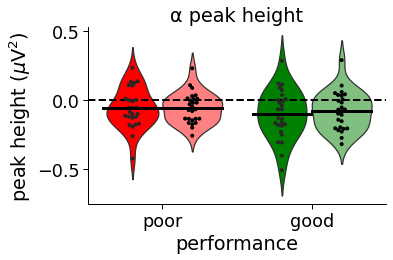

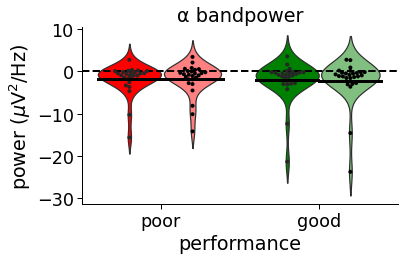

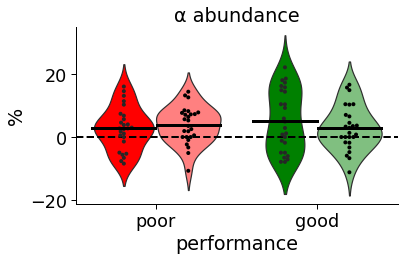

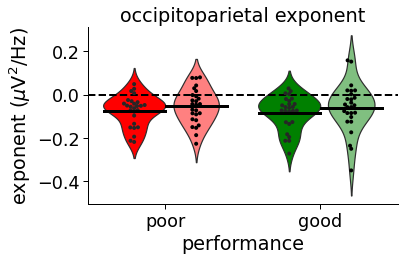

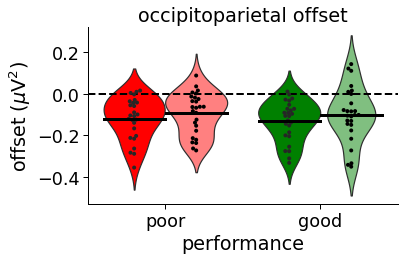

In [8]:
dp_plot.plot_violin_swarms(data=df_alpha_avg_diff, parameter='power', frequency_band='alpha', save_fig=True)
dp_plot.plot_violin_swarms(data=df_alpha_avg_diff, parameter='bandpower', frequency_band='alpha', save_fig=True)
dp_plot.plot_violin_swarms(data=df_alpha_avg_diff, parameter='peak_perc', frequency_band='alpha', save_fig=True)
dp_plot.plot_violin_swarms(data=df_alpha_avg_diff, parameter='exponent', frequency_band='alpha', save_fig=True)
dp_plot.plot_violin_swarms(data=df_alpha_avg_diff, parameter='offset', frequency_band='alpha', save_fig=True)
# dp_plot.plot_violin_swarms(data=df_alpha_avg_diff, parameter='auc', frequency_band='alpha', save_fig=True)
# dp_plot.plot_violin_swarms(data=df_alpha_avg_diff, parameter='auc_log_osc', frequency_band='alpha', save_fig=True)
# dp_plot.plot_violin_swarms(data=df_alpha_avg_diff, parameter='auc_lin_osc', frequency_band='alpha', save_fig=True)

# Theta Analyses


# Group that has theta oscillations identified

In [65]:
# preparing the dataframe
all_cols = df_theta_avg.columns
df_theta_avg_diff = df_theta_avg.query('bas_ret_diff == "diff"')[all_cols]
df_theta_avg_ret = df_theta_avg.query('bas_ret_diff == "ret"')[all_cols]
df_theta_avg_bas = df_theta_avg.query('bas_ret_diff == "bas"')[all_cols]

### THETA - AMPLITUDE (APERIODIC ADJUSTED POWER)

In [66]:
# Descriptive statistics 
df_theta_avg_diff.groupby(['bas_ret_diff', 'performance'])['power'].describe()

count      mean       std       min       25%  \
bas_ret_diff performance                                                  
diff         good          17.0  0.009222  0.053777 -0.103587 -0.025883   
             poor          17.0  0.039414  0.070561 -0.070570 -0.004020   

                               50%       75%       max  
bas_ret_diff performance                                
diff         good         0.017020  0.049378  0.112124  
             poor         0.020881  0.098304  0.176837

In [67]:
df_theta_avg.groupby(['bas_ret_diff'])['power'].describe()

,count,mean,std,min,25%,50%,75%,max
bas_ret_diff,,,,,,,,
bas,34.0,0.278019,0.067944,0.110340,0.243660,0.274993,0.330325,0.404146
diff,34.0,0.024318,0.063647,-0.103587,-0.010668,0.017683,0.054721,0.176837
ret,34.0,0.302337,0.077154,0.116238,0.269521,0.298530,0.356516,0.460608


In [68]:
# Normality with Shapiro Wilk
pg.normality(data=df_theta_avg_diff, dv='power', group='performance', method='shapiro')

,W,pval,normal
good,0.988301,0.997342,True
poor,0.951478,0.480316,True


In [69]:
# Pairwise t-test for unparametric alternative
pg.pairwise_ttests(data=df_theta_avg_diff, dv='power', within='performance', subject='sub_id', effsize='cohen')
# print(pg.wilcoxon(x=df_theta_avg_diff.query('performance == "good"')['power'].values, 
#         y=df_theta_avg_diff.query('performance == "poor"')['power'].values))

/Users/quirine/opt/anaconda3/envs/py3/lib/python3.7/site-packages/pingouin/pairwise.py:27: UserWarning: pairwise_ttests is deprecated, use pairwise_tests instead.
  warnings.warn("pairwise_ttests is deprecated, use pairwise_tests instead.", UserWarning)


,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,BF10,cohen
0,performance,good,poor,True,True,-1.588088,16.0,two-sided,0.131829,0.711,-0.481264


### Theta - Amplitude different from 0 (different from baseline)

In [70]:
theta_avg_bas = df_theta_avg_bas.groupby(['sub_id'])['power'].mean().values
theta_avg_ret = df_theta_avg_ret.groupby(['sub_id'])['power'].mean().values

# Normality
print(pg.normality(theta_avg_bas))
print(pg.normality(theta_avg_ret))

# Paired t-test or wilcoxon if data is not-parametric
print(pg.ttest(theta_avg_ret, theta_avg_bas, paired=True))
# pg.wilcoxon(alpha_avg_ret, alpha_avg_bas)

          W     pval  normal
0  0.981881  0.97225    True
          W      pval  normal
0  0.967923  0.781114    True
               T  dof alternative     p-val         CI95%   cohen-d   BF10  \
T-test  2.046912   16   two-sided  0.057458  [-0.0, 0.05]  0.355006  1.322   

           power  
T-test  0.280223  


### THETA - LOG power (APERIODIC ADJUSTED POWER)

In [71]:
# Descriptive statistics 
df_theta_avg_diff.groupby(['bas_ret_diff', 'performance'])['auc_log_osc'].describe()

count      mean       std       min       25%  \
bas_ret_diff performance                                                  
diff         good          17.0  0.033482  0.104605 -0.171644 -0.043723   
             poor          17.0  0.048002  0.139724 -0.233726 -0.043286   

                               50%       75%       max  
bas_ret_diff performance                                
diff         good         0.034856  0.100766  0.241885  
             poor         0.009905  0.168259  0.228699

In [72]:
df_theta_avg.groupby(['bas_ret_diff'])['auc_log_osc'].describe()

,count,mean,std,min,25%,50%,75%,max
bas_ret_diff,,,,,,,,
bas,34.0,0.556890,0.145618,0.228777,0.480067,0.576720,0.652521,0.835676
diff,34.0,0.040742,0.121759,-0.233726,-0.043613,0.025326,0.138962,0.241885
ret,34.0,0.597632,0.145601,0.241463,0.503477,0.637952,0.698876,0.843882


In [73]:
# Normality with Shapiro Wilk
pg.normality(data=df_theta_avg_diff, dv='auc_log_osc', group='performance', method='shapiro')

,W,pval,normal
good,0.994835,0.999995,True
poor,0.925070,0.179857,True


In [74]:
# Pairwise t-test for unparametric alternative
pg.pairwise_ttests(data=df_theta_avg_diff, dv='auc_log_osc', within='performance', subject='sub_id', effsize='cohen')
# print(pg.wilcoxon(x=df_theta_avg_diff.query('performance == "good"')['power'].values, 
#         y=df_theta_avg_diff.query('performance == "poor"')['power'].values))

/Users/quirine/opt/anaconda3/envs/py3/lib/python3.7/site-packages/pingouin/pairwise.py:27: UserWarning: pairwise_ttests is deprecated, use pairwise_tests instead.
  warnings.warn("pairwise_ttests is deprecated, use pairwise_tests instead.", UserWarning)


,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,BF10,cohen
0,performance,good,poor,True,True,-0.437107,16.0,two-sided,0.667876,0.271,-0.117654


### Theta - LOG power different from 0 (different from baseline)

In [75]:
theta_avg_bas = df_theta_avg_bas.groupby(['sub_id'])['auc_log_osc'].mean().values
theta_avg_ret = df_theta_avg_ret.groupby(['sub_id'])['auc_log_osc'].mean().values

# Normality
print(pg.normality(theta_avg_bas))
print(pg.normality(theta_avg_ret))

# Paired t-test or wilcoxon if data is not-parametric
print(pg.ttest(theta_avg_ret, theta_avg_bas, paired=True))
# pg.wilcoxon(alpha_avg_ret, alpha_avg_bas)

          W      pval  normal
0  0.964167  0.710612    True
          W     pval  normal
0  0.930772  0.22421    True
               T  dof alternative     p-val          CI95%   cohen-d   BF10  \
T-test  1.636063   16   two-sided  0.121343  [-0.01, 0.09]  0.295494  0.755   

           power  
T-test  0.208808  


### THETA - LINEAR power (APERIODIC ADJUSTED POWER)

In [76]:
# Descriptive statistics 
df_theta_avg_diff.groupby(['bas_ret_diff', 'performance'])['auc_lin_osc'].describe()

count      mean       std       min       25%  \
bas_ret_diff performance                                                  
diff         good          17.0  0.019308  1.476344 -3.782676 -0.538486   
             poor          17.0 -0.237397  1.348118 -3.080502 -0.967336   

                               50%       75%       max  
bas_ret_diff performance                                
diff         good        -0.030581  0.732661  3.160162  
             poor        -0.435756  0.669820  2.231235

In [77]:
df_theta_avg.groupby(['bas_ret_diff'])['auc_lin_osc'].describe()

,count,mean,std,min,25%,50%,75%,max
bas_ret_diff,,,,,,,,
bas,34.0,5.806534,2.140533,1.951101,4.385976,5.277208,7.098440,10.459997
diff,34.0,-0.109044,1.398185,-3.782676,-0.864757,-0.093109,0.716951,3.160162
ret,34.0,5.697490,2.244453,2.511635,3.945530,5.092819,6.973555,12.293693


In [78]:
# Normality with Shapiro Wilk
pg.normality(data=df_theta_avg_diff, dv='auc_lin_osc', group='performance', method='shapiro')

,W,pval,normal
good,0.941702,0.338927,True
poor,0.989401,0.998579,True


In [79]:
# Pairwise t-test for unparametric alternative
pg.pairwise_ttests(data=df_theta_avg_diff, dv='auc_lin_osc', within='performance', subject='sub_id', effsize='cohen')
# print(pg.wilcoxon(x=df_theta_avg_diff.query('performance == "good"')['power'].values, 
#         y=df_theta_avg_diff.query('performance == "poor"')['power'].values))

/Users/quirine/opt/anaconda3/envs/py3/lib/python3.7/site-packages/pingouin/pairwise.py:27: UserWarning: pairwise_ttests is deprecated, use pairwise_tests instead.
  warnings.warn("pairwise_ttests is deprecated, use pairwise_tests instead.", UserWarning)


,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,BF10,cohen
0,performance,good,poor,True,True,0.614183,16.0,two-sided,0.547729,0.294,0.181586


### Theta - LIN power different from 0 (different from baseline)

In [80]:
theta_avg_bas = df_theta_avg_bas.groupby(['sub_id'])['auc_lin_osc'].mean().values
theta_avg_ret = df_theta_avg_ret.groupby(['sub_id'])['auc_lin_osc'].mean().values

# Normality
print(pg.normality(theta_avg_bas))
print(pg.normality(theta_avg_ret))

# Paired t-test or wilcoxon if data is not-parametric
print(pg.ttest(theta_avg_ret, theta_avg_bas, paired=True))
# pg.wilcoxon(alpha_avg_ret, alpha_avg_bas)

         W      pval  normal
0  0.95485  0.537552    True
          W      pval  normal
0  0.927063  0.194305    True
               T  dof alternative     p-val          CI95%   cohen-d   BF10  \
T-test -0.401164   16   two-sided  0.693606  [-0.69, 0.47]  0.051233  0.268   

           power  
T-test  0.054543  


### THETA - CENTER FREQUENCY

In [81]:
# Descriptive statistics 
# df_theta_avg_diff.groupby(['bas_ret_diff', 'performance'])['cf'].describe()

In [82]:
# Normality with Shapiro Wilk
# print(pg.normality(data=df_theta_avg_diff, dv='cf', group='performance', method='shapiro'))

In [83]:
# Pairwise t-test for unparametric alternative
# pg.pairwise_ttests(data=df_theta_avg_diff, dv='cf', within='performance', subject='sub_id', effsize='cohen')
# print(pg.wilcoxon(x=df_theta_avg_diff.query('performance == "good"')['cf'].values, 
#         y=df_theta_avg_diff.query('performance == "poor"')['cf'].values))

### THETA - EXPONENT (we're not using exponent and offset for this sub-group)

In [84]:
# Descriptive statistics 
# df_theta_avg_diff.groupby(['bas_ret_diff', 'performance'])['exponent'].describe()

In [85]:
# Normality with Shapiro Wilk
# print(pg.normality(data=df_theta_avg_diff, dv='exponent', group='performance', method='shapiro'))

In [86]:
# Pairwise t-test for unparametric alternative
# print(pg.pairwise_ttests(data=df_theta_avg_diff, dv='exponent', within='performance', subject='sub_id', effsize='cohen'))
# print(pg.wilcoxon(x=df_theta_avg_diff.query('performance == "good"')['exponent'].values, 
#         y=df_theta_avg_diff.query('performance == "poor"')['exponent'].values))

#### Theta - EXPONENT different from 0 (different from baseline)

In [87]:
# print(pg.ttest(df_theta_avg_diff.query('performance == "good"')['exponent'].values, 0))
# print(pg.ttest(df_theta_avg_diff.query('performance == "good"')['exponent'].values, 0))

### THETA - OFFSET (we're not using exponent and offset for this sub-group)

In [88]:
# Descriptive statistics 
# df_theta_avg_diff.groupby(['bas_ret_diff', 'performance'])['offset'].describe()

In [89]:
# Normality with Shapiro Wilk
# print(pg.normality(data=df_theta_avg_diff, dv='offset', group='performance', method='shapiro'))

In [90]:
# Pairwise t-test for unparametric alternative
# print(pg.pairwise_ttests(data=df_theta_avg_diff, dv='offset', within='performance', subject='sub_id', effsize='cohen'))
# print(pg.wilcoxon(x=df_theta_avg_diff.query('performance == "good"')['offset'].values, 
#         y=df_theta_avg_diff.query('performance == "poor"')['offset'].values))

#### Theta - OFFSET different from 0 (different from baseline)

In [91]:
# print(pg.ttest(df_theta_avg_diff.query('performance == "good"')['offset'].values, 0))
# print(pg.ttest(df_theta_avg_diff.query('performance == "poor"')['offset'].values, 0))

### THETA - CENTER FREQUENCY PERCENTAGE OVER TRIALS

In [92]:
# Descriptive statistics 
df_theta_avg_diff.groupby(['bas_ret_diff', 'performance'])['peak_perc'].describe()

count      mean       std        min       25%  \
bas_ret_diff performance                                                   
diff         good          17.0 -0.284029  5.135104 -10.606061 -3.278689   
             poor          17.0 -2.792652  7.092778 -19.424460 -7.228916   

                               50%       75%       max  
bas_ret_diff performance                                
diff         good         0.000000  1.960784  8.080808  
             poor        -2.068966  2.155172  8.196721

In [93]:
df_theta_avg.groupby(['bas_ret_diff'])['peak_perc'].describe()

,count,mean,std,min,25%,50%,75%,max
bas_ret_diff,,,,,,,,
bas,34.0,68.857435,6.878765,55.263158,64.246777,68.816092,73.295455,84.000000
diff,34.0,-1.538340,6.228772,-19.424460,-5.496829,-0.530899,2.106575,8.196721
ret,34.0,67.319095,7.730752,53.469388,60.805627,68.256675,72.578241,85.074627


In [94]:
# Normality with Shapiro Wilk
print(pg.normality(data=df_theta_avg_diff, dv='peak_perc', group='performance', method='shapiro'))

             W      pval  normal
good  0.978257  0.939596    True
poor  0.958570  0.604781    True


In [95]:
# Pairwise t-test for unparametric alternative
print(pg.pairwise_ttests(data=df_theta_avg_diff, dv='peak_perc', within='performance', subject='sub_id', effsize='cohen'))
# print(pg.wilcoxon(x=df_theta_avg_diff.query('performance == "good"')['peak_perc'].values, 
#         y=df_theta_avg_diff.query('performance == "poor"')['peak_perc'].values))

      Contrast     A     B  Paired  Parametric         T   dof alternative  \
0  performance  good  poor    True        True  1.077013  16.0   two-sided   

      p-unc   BF10     cohen  
0  0.297446  0.411  0.405152  


/Users/quirine/opt/anaconda3/envs/py3/lib/python3.7/site-packages/pingouin/pairwise.py:27: UserWarning: pairwise_ttests is deprecated, use pairwise_tests instead.
  warnings.warn("pairwise_ttests is deprecated, use pairwise_tests instead.", UserWarning)


#### Theta - Percent peak different from 0 (different from baseline)

In [96]:
theta_avg_bas = df_theta_avg_bas.groupby(['sub_id'])['peak_perc'].mean().values
theta_avg_ret = df_theta_avg_ret.groupby(['sub_id'])['peak_perc'].mean().values

# Normality
print(pg.normality(theta_avg_bas))
print(pg.normality(theta_avg_ret))

# Paired t-test or wilcoxon if data is not-parametric
print(pg.ttest(theta_avg_ret, theta_avg_bas, paired=True))
# pg.wilcoxon(alpha_avg_ret, alpha_avg_bas)

          W      pval  normal
0  0.983188  0.980503    True
          W      pval  normal
0  0.956419  0.565445    True
               T  dof alternative     p-val          CI95%   cohen-d   BF10  \
T-test -1.622581   16   two-sided  0.124215  [-3.55, 0.47]  0.226716  0.743   

          power  
T-test  0.14225  


### THETA - BANDPOWER

In [97]:
# Descriptive statistics 
df_theta_avg_diff.groupby(['bas_ret_diff', 'performance'])['bandpower'].describe()

count      mean       std       min       25%  \
bas_ret_diff performance                                                  
diff         good          17.0 -0.169534  0.849729 -2.462943 -0.534875   
             poor          17.0 -0.307441  0.836711 -2.147379 -0.920526   

                               50%       75%       max  
bas_ret_diff performance                                
diff         good        -0.103772  0.215674  1.290917  
             poor        -0.314046  0.163192  1.359465

In [98]:
# Normality with Shapiro Wilk
print(pg.normality(data=df_theta_avg_diff, dv='bandpower', group='performance', method='shapiro'))

             W      pval  normal
good  0.942408  0.347866    True
poor  0.977403  0.929832    True


In [99]:
# Pairwise t-test for unparametric alternative
# print(pg.pairwise_ttests(data=df_theta_avg_diff, dv='bandpower', within='performance', subject='sub_id', effsize='cohen'))
print(pg.wilcoxon(x=df_theta_avg_diff.query('performance == "good"')['bandpower'].values, 
        y=df_theta_avg_diff.query('performance == "poor"')['bandpower'].values))

          W-val alternative     p-val       RBC      CLES
Wilcoxon   70.0   two-sided  0.781906  0.084967  0.574394


#### Theta - Bandpower different from 0 (different from baseline)

In [100]:
theta_avg_bas = df_theta_avg_bas.groupby(['sub_id'])['bandpower'].mean().values
theta_avg_ret = df_theta_avg_ret.groupby(['sub_id'])['bandpower'].mean().values

# Normality
print(pg.normality(theta_avg_bas))
print(pg.normality(theta_avg_ret))

# Paired t-test or wilcoxon if data is not-parametric
print(pg.ttest(theta_avg_ret, theta_avg_bas, paired=True))
# pg.wilcoxon(alpha_avg_ret, alpha_avg_bas)

          W      pval  normal
0  0.956651  0.569626    True
          W      pval  normal
0  0.951703  0.484004    True
               T  dof alternative     p-val         CI95%   cohen-d   BF10  \
T-test -1.386197   16   two-sided  0.184702  [-0.6, 0.13]  0.148081  0.562   

           power  
T-test  0.088612  


### THETA - FIGURES

theta


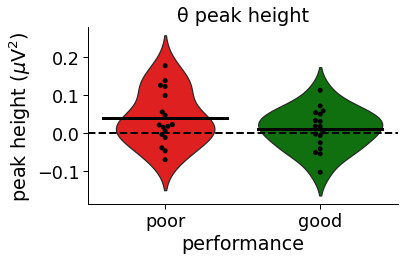

theta


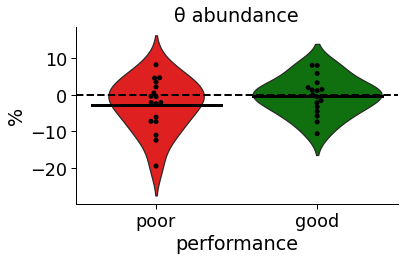

theta


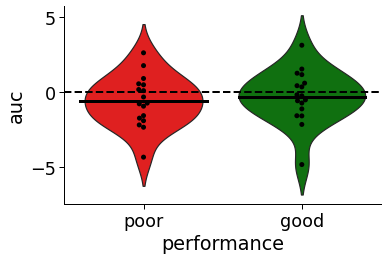

theta


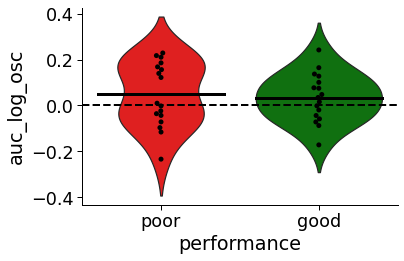

theta


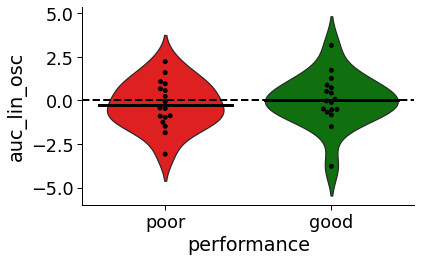

In [101]:
dp_plot.plot_violin_swarms(data=df_theta_avg_diff, parameter='power', frequency_band='theta', save_fig=True)
# dp_plot.plot_violin_swarms(data=df_theta_avg_diff, parameter='cf', frequency_band='theta', save_fig=True)
dp_plot.plot_violin_swarms(data=df_theta_avg_diff, parameter='peak_perc', frequency_band='theta', save_fig=True)
# dp_plot.plot_violin_swarms(data=df_theta_avg_diff, parameter='bandpower', frequency_band='theta', save_fig=True)
# dp_plot.plot_violin_swarms(data=df_theta_avg_diff, parameter='exponent', frequency_band='theta', save_fig=False)
# dp_plot.plot_violin_swarms(data=df_theta_avg_diff, parameter='offset', frequency_band='theta', save_fig=False)
dp_plot.plot_violin_swarms(data=df_theta_avg_diff, parameter='auc', frequency_band='theta', save_fig=True)
dp_plot.plot_violin_swarms(data=df_theta_avg_diff, parameter='auc_log_osc', frequency_band='theta', save_fig=True)
dp_plot.plot_violin_swarms(data=df_theta_avg_diff, parameter='auc_lin_osc', frequency_band='theta', save_fig=True)



# Group that DOES NOT HAVE theta oscillations identified

In [102]:
# preparing the dataframe
all_cols = df_no_theta_avg.columns
df_no_theta_avg_diff = df_no_theta_avg.query('bas_ret_diff == "diff"')[all_cols]
df_no_theta_avg_ret = df_no_theta_avg.query('bas_ret_diff == "ret"')[all_cols]
df_no_theta_avg_bas = df_no_theta_avg.query('bas_ret_diff == "bas"')[all_cols]

### NO THETA - EXPONENT


In [103]:
# Descriptive statistics 
df_no_theta_avg_diff.groupby(['bas_ret_diff', 'performance'])['exponent'].describe()

count      mean       std       min       25%  \
bas_ret_diff performance                                                  
diff         good          17.0 -0.091373  0.165998 -0.485585 -0.227766   
             poor          17.0 -0.077170  0.148678 -0.603525 -0.095803   

                               50%       75%       max  
bas_ret_diff performance                                
diff         good        -0.059751  0.017782  0.137124  
             poor        -0.069604 -0.012249  0.050033

In [104]:
# Normality with Shapiro Wilk
print(pg.normality(data=df_no_theta_avg_diff, dv='exponent', group='performance', method='shapiro'))

             W      pval  normal
good  0.943181  0.357868    True
poor  0.648938  0.000032   False


In [105]:
# Pairwise t-test for unparametric alternative
print(pg.pairwise_ttests(data=df_no_theta_avg_diff, dv='exponent', within='performance', subject='sub_id', effsize='cohen'))
# print(pg.wilcoxon(x=df_no_theta_avg_diff.query('performance == "good"')['exponent'].values, 
#         y=df_no_theta_avg_diff.query('performance == "poor"')['exponent'].values))

      Contrast     A     B  Paired  Parametric         T   dof alternative  \
0  performance  good  poor    True        True -0.172204  15.0   two-sided   

      p-unc   BF10     cohen  
0  0.865579  0.259 -0.035936  


/Users/quirine/opt/anaconda3/envs/py3/lib/python3.7/site-packages/pingouin/pairwise.py:27: UserWarning: pairwise_ttests is deprecated, use pairwise_tests instead.
  warnings.warn("pairwise_ttests is deprecated, use pairwise_tests instead.", UserWarning)


#### NO  Theta - EXPONENT different from 0 (different from baseline)

In [106]:
theta_avg_bas = df_no_theta_avg_bas.groupby(['sub_id'])['exponent'].mean().values
theta_avg_ret = df_no_theta_avg_ret.groupby(['sub_id'])['exponent'].mean().values

# Normality
print(pg.normality(theta_avg_bas))
print(pg.normality(theta_avg_ret))

# Paired t-test or wilcoxon if data is not-parametric
print(pg.ttest(theta_avg_ret, theta_avg_bas, paired=True))
# pg.wilcoxon(alpha_avg_ret, alpha_avg_bas)

          W     pval  normal
0  0.960863  0.67748    True
          W      pval  normal
0  0.955652  0.584099    True
               T  dof alternative     p-val          CI95%   cohen-d   BF10  \
T-test -2.168625   15   two-sided  0.046598  [-0.16, -0.0]  0.196037  1.588   

           power  
T-test  0.113809  


### NO THETA - OFFSET 

In [107]:
# Descriptive statistics 
df_no_theta_avg_diff.groupby(['bas_ret_diff', 'performance'])['offset'].describe()

count      mean       std       min       25%  \
bas_ret_diff performance                                                  
diff         good          17.0 -0.130203  0.172118 -0.472971 -0.298556   
             poor          17.0 -0.110253  0.157066 -0.616645 -0.122044   

                               50%       75%       max  
bas_ret_diff performance                                
diff         good        -0.094330  0.013358  0.143682  
             poor        -0.110686 -0.007949  0.061552

In [108]:
# Normality with Shapiro Wilk
print(pg.normality(data=df_no_theta_avg_diff, dv='offset', group='performance', method='shapiro'))

            W      pval  normal
good  0.95677  0.571790    True
poor  0.76438  0.000686   False


In [109]:
# Pairwise t-test for unparametric alternative
print(pg.pairwise_ttests(data=df_no_theta_avg_diff, dv='offset', within='performance', subject='sub_id', effsize='cohen'))
# print(pg.wilcoxon(x=df_no_theta_avg_diff.query('performance == "good"')['offset'].values, 
#         y=df_no_theta_avg_diff.query('performance == "poor"')['offset'].values))

      Contrast     A     B  Paired  Parametric        T   dof alternative  \
0  performance  good  poor    True        True -0.23106  15.0   two-sided   

      p-unc   BF10    cohen  
0  0.820391  0.262 -0.05807  


/Users/quirine/opt/anaconda3/envs/py3/lib/python3.7/site-packages/pingouin/pairwise.py:27: UserWarning: pairwise_ttests is deprecated, use pairwise_tests instead.
  warnings.warn("pairwise_ttests is deprecated, use pairwise_tests instead.", UserWarning)


#### NO Theta - OFFSET different from 0 (different from baseline)

In [110]:
theta_avg_bas = df_no_theta_avg_bas.groupby(['sub_id'])['offset'].mean().values
theta_avg_ret = df_no_theta_avg_ret.groupby(['sub_id'])['offset'].mean().values

# Normality
print(pg.normality(theta_avg_bas))
print(pg.normality(theta_avg_ret))

# Paired t-test or wilcoxon if data is not-parametric
print(pg.ttest(theta_avg_ret, theta_avg_bas, paired=True))
# pg.wilcoxon(alpha_avg_ret, alpha_avg_bas)

          W      pval  normal
0  0.951755  0.517996    True
          W      pval  normal
0  0.971016  0.854787    True
               T  dof alternative     p-val           CI95%   cohen-d   BF10  \
T-test -3.170448   15   two-sided  0.006336  [-0.19, -0.04]  0.318973  7.986   

           power  
T-test  0.222998  


### NO THETA - BANDPOWER

In [111]:
# Descriptive statistics 
# df_no_theta_avg_diff.groupby(['bas_ret_diff', 'performance'])['bandpower'].describe()

In [112]:
# Normality with Shapiro Wilk
# print(pg.normality(data=df_no_theta_avg_diff, dv='bandpower', group='performance', method='shapiro'))

In [113]:
# Pairwise t-test for unparametric alternative
# print(pg.pairwise_ttests(data=df_no_theta_avg_diff, dv='bandpower', within='performance', subject='sub_id', effsize='cohen'))
# print(pg.wilcoxon(x=df_no_theta_avg_diff.query('performance == "good"')['bandpower'].values, 
#         y=df_no_theta_avg_diff.query('performance == "poor"')['bandpower'].values))

#### Theta - Bandpower different from 0 (different from baseline)

In [114]:
# theta_avg_bas = df_no_theta_avg_bas.groupby(['sub_id'])['bandpower'].mean().values
# theta_avg_ret = df_no_theta_avg_ret.groupby(['sub_id'])['bandpower'].mean().values

# # Normality
# print(pg.normality(theta_avg_bas))
# print(pg.normality(theta_avg_ret))

# # Paired t-test or wilcoxon if data is not-parametric
# print(pg.ttest(theta_avg_ret, theta_avg_bas, paired=True))
# # pg.wilcoxon(theta_avg_ret, theta_avg_bas)

### NO THETA - FIGURES

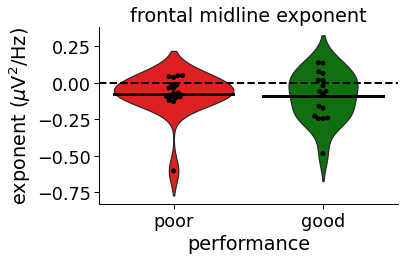

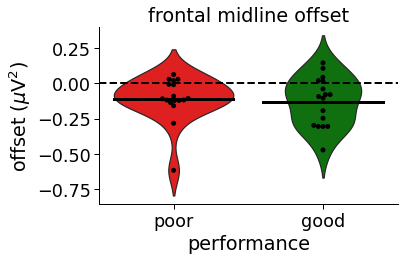

In [115]:
# dp_plot.plot_violin_swarms(data=df_no_theta_avg_diff, parameter='power', frequency_band='theta', save_fig=False)
# dp_plot.plot_violin_swarms(data=df_no_theta_avg_diff, parameter='cf', frequency_band='theta', save_fig=False)
# dp_plot.plot_violin_swarms(data=df_no_theta_avg_diff, parameter='peak_perc', frequency_band='theta', save_fig=False)
dp_plot.plot_violin_swarms(data=df_no_theta_avg_diff, parameter='exponent', frequency_band='theta', save_fig=False)
dp_plot.plot_violin_swarms(data=df_no_theta_avg_diff, parameter='offset', frequency_band='theta', save_fig=False)

# Combined with and without theta oscillations for aperiodic analysis only

In [116]:
df_alpha_avg_diff.head()

,performance,lateralization,bas_ret_diff,sub_id,trial_n,exponent,offset,power,cf,peak_perc,bandpower,auc,auc_log_osc,auc_lin_osc,r2s,wm_capacity,osc_presence
1,good,contra,diff,1.0,73.648438,-0.029541,-0.091696,-0.070188,-0.297870,-6.000000,-2.756096,-11.371259,-0.293643,-10.176183,NaN,3.003704,1.0
4,good,ipsi,diff,1.0,73.648438,0.158127,0.142061,-0.070799,-0.194992,-6.666667,-3.055478,-12.128853,-0.520705,-10.982709,NaN,3.003704,1.0
7,poor,contra,diff,1.0,70.145299,-0.079227,-0.167419,-0.056867,-0.166147,0.000000,-2.526858,-10.560398,-0.246325,-9.433092,NaN,3.003704,1.0
10,poor,ipsi,diff,1.0,70.145299,-0.114677,-0.178668,0.004511,-0.090166,-5.035971,-2.977895,-12.062198,-0.251907,-10.827544,NaN,3.003704,1.0
1,good,contra,diff,2.0,63.866667,-0.050179,-0.097260,-0.023215,0.325344,0.781250,-0.127916,-0.564120,-0.052918,-0.361849,NaN,2.961111,1.0


In [117]:
df_theta_avg_diff.head()

,performance,bas_ret_diff,sub_id,trial_n,exponent,offset,power,cf,peak_perc,bandpower,auc,auc_log_osc,auc_lin_osc,r2s,wm_capacity,osc_presence
1,good,diff,1.0,74.340580,0.004993,-0.019641,-0.051673,0.257649,8.000000,-0.321517,-0.725107,-0.058265,-0.538486,NaN,3.003704,1.0
4,poor,diff,1.0,67.592308,-0.157279,-0.204086,0.176837,-0.233425,-19.424460,0.066124,0.176964,0.185625,0.571280,NaN,3.003704,1.0
1,good,diff,2.0,64.838983,0.075985,0.063739,0.057766,0.240711,-1.562500,0.209568,0.351671,0.015797,0.430039,NaN,2.961111,1.0
4,poor,diff,2.0,60.938053,-0.017331,-0.042186,-0.070570,-0.146736,8.196721,-1.120507,-2.341159,-0.233726,-1.847530,NaN,2.961111,1.0
1,good,diff,3.0,90.190184,-0.110556,-0.159997,0.017020,0.142733,-0.561798,-0.855452,-1.573139,0.047794,-0.826773,NaN,3.553704,1.0


In [118]:
# preparing the dataframe & combining with and without oscillations
df_all_theta_diff = pd.concat([df_theta_avg_diff, df_no_theta_avg_diff])
df_all_theta_ret = pd.concat([df_theta_avg_ret, df_no_theta_avg_ret])
df_all_theta_bas = pd.concat([df_theta_avg_bas, df_no_theta_avg_bas])

### ALL THETA - EXPONENT

In [119]:
# Descriptive statistics 
df_all_theta_bas.groupby(['bas_ret_diff', 'performance'])['exponent'].describe()

count      mean       std       min       25%  \
bas_ret_diff performance                                                  
bas          good          34.0  1.137978  0.311614  0.386966  1.007645   
             poor          34.0  1.117353  0.293817  0.422574  1.000052   

                               50%       75%       max  
bas_ret_diff performance                                
bas          good         1.146928  1.292385  1.815274  
             poor         1.128876  1.299791  1.822101

In [120]:
# Descriptive statistics 
df_all_theta_ret.groupby(['bas_ret_diff', 'performance'])['exponent'].describe()

count      mean       std       min       25%  \
bas_ret_diff performance                                                  
ret          good          34.0  1.091546  0.368833 -0.098618  0.872777   
             poor          34.0  1.062198  0.356328 -0.094554  0.907199   

                               50%       75%       max  
bas_ret_diff performance                                
ret          good         1.112518  1.316232  1.757133  
             poor         1.087154  1.262541  1.809852

In [121]:
# Descriptive statistics 
df_all_theta_diff.groupby(['bas_ret_diff', 'performance'])['exponent'].describe()

count      mean       std       min       25%  \
bas_ret_diff performance                                                  
diff         good          34.0 -0.046432  0.134236 -0.485585 -0.104453   
             poor          34.0 -0.055155  0.120717 -0.603525 -0.095590   

                               50%       75%       max  
bas_ret_diff performance                                
diff         good        -0.029067  0.052434  0.137124  
             poor        -0.041825  0.020688  0.091599

In [122]:
df_all_theta_ret.groupby(['bas_ret_diff'])['exponent'].describe()

,count,mean,std,min,25%,50%,75%,max
bas_ret_diff,,,,,,,,
ret,68.0,1.076872,0.360221,-0.098618,0.888767,1.093496,1.305036,1.809852


In [123]:
df_all_theta_bas.groupby(['bas_ret_diff'])['exponent'].describe()

,count,mean,std,min,25%,50%,75%,max
bas_ret_diff,,,,,,,,
bas,68.0,1.127666,0.300757,0.386966,1.001268,1.137155,1.297961,1.822101


In [124]:
# Normality with Shapiro Wilk
print(pg.normality(data=df_all_theta_diff, dv='exponent', group='performance', method='shapiro'))

             W      pval  normal
good  0.918874  0.015017   False
poor  0.747968  0.000003   False


In [125]:
# Pairwise t-test for unparametric alternative
# pg.pairwise_ttests(data=df_all_theta_diff, dv='exponent', within='performance', subject='sub_id', effsize='cohen')
pg.wilcoxon(x=df_all_theta_diff.query('performance == "good"')['exponent'].values, 
        y=df_all_theta_diff.query('performance == "poor"')['exponent'].values)

,W-val,alternative,p-val,RBC,CLES
Wilcoxon,280.0,two-sided,0.771322,0.058824,0.535467


#### ALL Theta - EXPONENT different from 0 (different from baseline)

In [126]:
theta_avg_bas = df_all_theta_bas.groupby(['sub_id'])['exponent'].mean().values
theta_avg_ret = df_all_theta_ret.groupby(['sub_id'])['exponent'].mean().values

# Normality
print(pg.normality(theta_avg_bas))
print(pg.normality(theta_avg_ret))

# Paired t-test or wilcoxon if data is not-parametric
print(pg.ttest(theta_avg_ret, theta_avg_bas, paired=True))
# pg.wilcoxon(theta_avg_ret, theta_avg_bas)

          W      pval  normal
0  0.974653  0.618235    True
          W      pval  normal
0  0.937522  0.057565    True
               T  dof alternative     p-val           CI95%   cohen-d  BF10  \
T-test -2.366193   32   two-sided  0.024193  [-0.09, -0.01]  0.141305  2.08   

           power  
T-test  0.123525  


### ALL THETA - OFFSET 

In [127]:
# Descriptive statistics 
df_all_theta_diff.groupby(['bas_ret_diff', 'performance'])['offset'].describe()

count      mean       std       min       25%  \
bas_ret_diff performance                                                  
diff         good          34.0 -0.085089  0.146189 -0.472971 -0.173318   
             poor          34.0 -0.092748  0.130706 -0.616645 -0.129143   

                               50%       75%       max  
bas_ret_diff performance                                
diff         good        -0.074881  0.011551  0.143682  
             poor        -0.093784  0.009064  0.072711

In [128]:
df_all_theta_bas.groupby(['bas_ret_diff'])['offset'].describe()

,count,mean,std,min,25%,50%,75%,max
bas_ret_diff,,,,,,,,
bas,68.0,0.897219,0.293535,0.275454,0.68911,0.902674,1.134996,1.40568


In [129]:
df_all_theta_ret.groupby(['bas_ret_diff'])['offset'].describe()

,count,mean,std,min,25%,50%,75%,max
bas_ret_diff,,,,,,,,
ret,68.0,0.808301,0.347282,0.019298,0.608835,0.830102,1.090257,1.385209


In [130]:
# Normality with Shapiro Wilk
print(pg.normality(data=df_all_theta_diff, dv='offset', group='performance', method='shapiro'))

             W      pval  normal
good  0.959966  0.242611    True
poor  0.838140  0.000154   False


In [131]:
# Pairwise t-test for unparametric alternative
# print(pg.pairwise_ttests(data=df_all_theta_diff, dv='offset', within='performance', subject='sub_id', effsize='cohen'))
pg.wilcoxon(x=df_all_theta_diff.query('performance == "good"')['offset'].values, 
        y=df_all_theta_diff.query('performance == "poor"')['offset'].values)

,W-val,alternative,p-val,RBC,CLES
Wilcoxon,283.0,two-sided,0.81083,0.048739,0.522491


#### ALL Theta - OFFSET different from 0 (different from baseline)

In [132]:
theta_avg_bas = df_all_theta_bas.groupby(['sub_id'])['offset'].mean().values
theta_avg_ret = df_all_theta_ret.groupby(['sub_id'])['offset'].mean().values

# Normality
print(pg.normality(theta_avg_bas))
print(pg.normality(theta_avg_ret))

# Paired t-test or wilcoxon if data is not-parametric
print(pg.ttest(theta_avg_ret, theta_avg_bas, paired=True))
# pg.wilcoxon(theta_avg_ret, theta_avg_bas)

          W      pval  normal
0  0.970579  0.496363    True
         W      pval  normal
0  0.96658  0.391962    True
               T  dof alternative     p-val           CI95%   cohen-d    BF10  \
T-test -4.088515   32   two-sided  0.000273  [-0.13, -0.04]  0.267038  102.81   

           power  
T-test  0.318788  


### ALL THETA - BANDPOWER


In [133]:
# Descriptive statistics 
df_all_theta_diff.groupby(['bas_ret_diff', 'performance'])['bandpower'].describe()

count      mean       std       min       25%  \
bas_ret_diff performance                                                  
diff         good          34.0 -0.255136  0.728222 -2.462943 -0.762664   
             poor          34.0 -0.295477  0.630640 -2.147379 -0.694160   

                               50%       75%       max  
bas_ret_diff performance                                
diff         good        -0.222182  0.214147  1.290917  
             poor        -0.214792  0.046095  1.359465

In [134]:
# Descriptive statistics 
df_all_theta_bas.groupby(['bas_ret_diff'])['bandpower'].describe()

,count,mean,std,min,25%,50%,75%,max
bas_ret_diff,,,,,,,,
bas,68.0,4.044592,1.606483,1.907776,2.71264,3.799502,4.904055,7.694839


In [135]:
# Descriptive statistics 
df_all_theta_ret.groupby(['bas_ret_diff'])['bandpower'].describe()

,count,mean,std,min,25%,50%,75%,max
bas_ret_diff,,,,,,,,
ret,68.0,3.769286,1.613997,1.44789,2.592079,3.512521,4.656106,8.628365


In [136]:
# Normality with Shapiro Wilk
print(pg.normality(data=df_all_theta_diff, dv='bandpower', group='performance', method='shapiro'))

             W      pval  normal
good  0.970303  0.469880    True
poor  0.953185  0.152913    True


In [137]:
# Pairwise t-test for unparametric alternative
print(pg.pairwise_ttests(data=df_all_theta_diff, dv='bandpower', within='performance', subject='sub_id', effsize='cohen'))
# print(pg.wilcoxon(x=df_all_theta_diff.query('performance == "good"')['bandpower'].values, 
#         y=df_all_theta_diff.query('performance == "poor"')['bandpower'].values))

      Contrast     A     B  Paired  Parametric        T   dof alternative  \
0  performance  good  poor    True        True  0.15952  32.0   two-sided   

      p-unc   BF10    cohen  
0  0.874262  0.188  0.02928  


/Users/quirine/opt/anaconda3/envs/py3/lib/python3.7/site-packages/pingouin/pairwise.py:27: UserWarning: pairwise_ttests is deprecated, use pairwise_tests instead.
  warnings.warn("pairwise_ttests is deprecated, use pairwise_tests instead.", UserWarning)


#### Theta - Bandpower different from 0 (different from baseline)

In [138]:
theta_avg_bas = df_all_theta_bas.groupby(['sub_id'])['bandpower'].mean().values
theta_avg_ret = df_all_theta_ret.groupby(['sub_id'])['bandpower'].mean().values

# Normality
print(pg.normality(theta_avg_bas))
print(pg.normality(theta_avg_ret))

# Paired t-test or wilcoxon if data is not-parametric
# print(pg.ttest(theta_avg_ret, theta_avg_bas, paired=True))
pg.wilcoxon(theta_avg_ret, theta_avg_bas)

          W      pval  normal
0  0.930016  0.035031   False
          W      pval  normal
0  0.935404  0.049996   False


,W-val,alternative,p-val,RBC,CLES
Wilcoxon,135.0,two-sided,0.009574,-0.518717,0.448118


### ALL THETA - FIGURES

theta


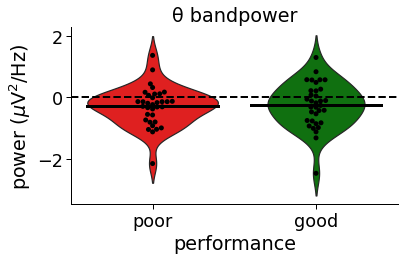

theta


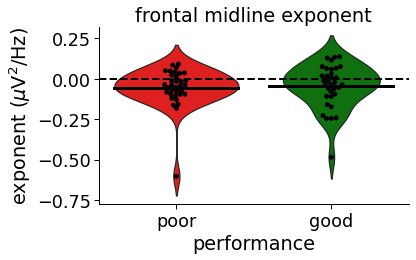

theta


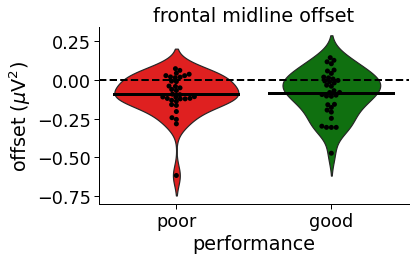

In [139]:
# dp_plot.plot_violin_swarms(data=df_all_theta_diff, parameter='power', frequency_band='theta', save_fig=False)
# dp_plot.plot_violin_swarms(data=df_all_theta_diff, parameter='cf', frequency_band='theta', save_fig=False)
# dp_plot.plot_violin_swarms(data=df_all_theta_diff, parameter='peak_perc', frequency_band='theta', save_fig=False)
dp_plot.plot_violin_swarms(data=df_all_theta_diff, parameter='bandpower', frequency_band='theta', save_fig=True)
dp_plot.plot_violin_swarms(data=df_all_theta_diff, parameter='exponent', frequency_band='theta', save_fig=True)
dp_plot.plot_violin_swarms(data=df_all_theta_diff, parameter='offset', frequency_band='theta', save_fig=True)

# THETA vs NO THETA

In [140]:
# Prepare dataframe difference --> basically ignore performance for this
df_all_theta_diff_avg = df_all_theta_diff.groupby('sub_id').mean()

# Replace 1.0 and 0.0 with yes or no for the presence of an oscillation
df_all_theta_diff_avg.loc[df_all_theta_diff_avg.osc_presence == 0.0, 'osc_presence'] = 'no'
df_all_theta_diff_avg.loc[df_all_theta_diff_avg.osc_presence == 1.0, 'osc_presence'] = 'yes'


# Prepare dataframe baseline --> basically ignore performance for this
df_all_theta_bas_avg = df_all_theta_bas.groupby('sub_id').mean()

# Replace 1.0 and 0.0 with yes or no for the presence of an oscillation
df_all_theta_bas_avg.loc[df_all_theta_bas_avg.osc_presence == 0.0, 'osc_presence'] = 'no'
df_all_theta_bas_avg.loc[df_all_theta_bas_avg.osc_presence == 1.0, 'osc_presence'] = 'yes'


# Prepare dataframe retention --> basically ignore performance for this
df_all_theta_ret_avg = df_all_theta_ret.groupby('sub_id').mean()

# Replace 1.0 and 0.0 with yes or no for the presence of an oscillation
df_all_theta_ret_avg.loc[df_all_theta_ret_avg.osc_presence == 0.0, 'osc_presence'] = 'no'
df_all_theta_ret_avg.loc[df_all_theta_ret_avg.osc_presence == 1.0, 'osc_presence'] = 'yes'

In [141]:
df_all_theta_diff_avg.head()

,trial_n,exponent,offset,power,cf,peak_perc,bandpower,auc,auc_log_osc,auc_lin_osc,r2s,wm_capacity,osc_presence
sub_id,,,,,,,,,,,,,
1.0,70.966444,-0.076143,-0.111864,0.062582,0.012112,-5.712230,-0.127696,-0.274071,0.063680,0.016397,NaN,3.003704,yes
2.0,62.888518,0.029327,0.010777,-0.006402,0.046987,3.317111,-0.455470,-0.994744,-0.108964,-0.708745,NaN,2.961111,yes
3.0,59.193131,-0.146487,-0.207330,0.018951,0.105777,1.473487,-0.616269,-1.254166,0.138247,-0.451294,NaN,3.553704,yes
4.0,66.352151,0.044015,-0.031590,-0.009829,-0.720896,0.496269,-1.749751,-3.368050,-0.038773,-2.341748,NaN,2.544444,yes
5.0,63.914362,-0.161359,-0.221981,0.060434,0.079386,-8.079994,-0.366972,-0.666698,0.048692,-0.054681,NaN,2.618519,no


#### Exponent statistics - RETENTION

In [142]:
# Descriptive statistics 
df_all_theta_ret_avg.groupby(['osc_presence'])['exponent'].describe()

,count,mean,std,min,25%,50%,75%,max
osc_presence,,,,,,,,
no,16.0,0.950840,0.440542,-0.096586,0.777069,0.954172,1.299030,1.783492
yes,17.0,1.206671,0.215012,0.896768,1.066437,1.115937,1.326109,1.626501


In [143]:
# Normality with Shapiro Wilk
pg.normality(data=df_all_theta_ret_avg, dv='exponent', group='osc_presence', method='shapiro')

,W,pval,normal
yes,0.932071,0.235673,True
no,0.955652,0.584099,True


In [144]:
# Test for equal variance between groups
pg.homoscedasticity(data=df_all_theta_ret_avg, dv='exponent', group='osc_presence', method='levene')

,W,pval,equal_var
levene,4.127401,0.050841,True


In [145]:
# t-test for unparametric alternative
pg.ttest(df_all_theta_ret_avg.query('osc_presence == "yes"')['exponent'].values, 
               df_all_theta_ret_avg.query('osc_presence == "no"')['exponent'].values)

# unparametric alternative
# pg.mwu(df_all_theta_ret_avg.query('osc_presence == "yes"')['exponent'].values, 
#                df_all_theta_ret_avg.query('osc_presence == "no"')['exponent'].values)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,2.099428,21.468153,two-sided,0.04777,"[0.0, 0.51]",0.745483,1.712,0.545304


#### Exponent statistics - DIFFERENCE

In [146]:
# Descriptive statistics 
df_all_theta_diff_avg.groupby(['osc_presence'])['exponent'].describe()

,count,mean,std,min,25%,50%,75%,max
osc_presence,,,,,,,,
no,16.0,-0.078883,0.145498,-0.544555,-0.131685,-0.040364,0.007940,0.089678
yes,17.0,-0.017316,0.066523,-0.146487,-0.076143,-0.010207,0.026483,0.100438


In [147]:
# Normality with Shapiro Wilk
pg.normality(data=df_all_theta_diff_avg, dv='exponent', group='osc_presence', method='shapiro')

,W,pval,normal
yes,0.978348,0.940588,True
no,0.776361,0.001344,False


In [148]:
# Test for equal variance between groups
pg.homoscedasticity(data=df_all_theta_diff_avg, dv='exponent', group='osc_presence', method='levene')

,W,pval,equal_var
levene,1.638283,0.210057,True


In [149]:
# t-test for unparametric alternative
# pg.ttest(df_all_theta_diff_avg.query('osc_presence == "yes"')['exponent'].values, 
#                df_all_theta_diff_avg.query('osc_presence == "no"')['exponent'].values)

# unparametric alternative
pg.mwu(df_all_theta_diff_avg.query('osc_presence == "yes"')['exponent'].values, 
               df_all_theta_diff_avg.query('osc_presence == "no"')['exponent'].values)

,U-val,alternative,p-val,RBC,CLES
MWU,169.0,two-sided,0.241715,-0.242647,0.621324


#### Exponent statistics - BASELINE

In [150]:
# Descriptive statistics 
df_all_theta_bas_avg.groupby(['osc_presence'])['exponent'].describe()

,count,mean,std,min,25%,50%,75%,max
osc_presence,,,,,,,,
no,16.0,1.029723,0.360213,0.447969,0.760303,1.088487,1.260005,1.818688
yes,17.0,1.223986,0.206608,0.910752,1.080517,1.182001,1.335610,1.619452


In [151]:
# Normality with Shapiro Wilk
pg.normality(data=df_all_theta_bas_avg, dv='exponent', group='osc_presence', method='shapiro')

,W,pval,normal
yes,0.926606,0.190899,True
no,0.960863,0.677480,True


In [152]:
# Test for equal variance between groups
pg.homoscedasticity(data=df_all_theta_bas_avg, dv='exponent', group='osc_presence', method='levene')

,W,pval,equal_var
levene,4.542538,0.041097,False


In [153]:
# t-test for unparametric alternative
# pg.ttest(df_all_theta_bas_avg.query('osc_presence == "yes"')['exponent'].values, 
#                df_all_theta_bas_avg.query('osc_presence == "no"')['exponent'].values)

# unparametric alternative
pg.mwu(df_all_theta_bas_avg.query('osc_presence == "yes"')['exponent'].values, 
               df_all_theta_bas_avg.query('osc_presence == "no"')['exponent'].values)

,U-val,alternative,p-val,RBC,CLES
MWU,177.0,two-sided,0.144596,-0.301471,0.650735


### Offset statistics - DIFFERNCE

In [154]:
# Descriptive statistics 
df_all_theta_diff_avg.groupby(['osc_presence'])['offset'].describe()

,count,mean,std,min,25%,50%,75%,max
osc_presence,,,,,,,,
no,16.0,-0.114363,0.144286,-0.544808,-0.161847,-0.101278,-0.021627,0.06618
yes,17.0,-0.057609,0.086225,-0.207330,-0.111864,-0.034253,-0.005350,0.09971


In [155]:
# Normality with Shapiro Wilk
pg.normality(data=df_all_theta_diff_avg, dv='offset', group='osc_presence', method='shapiro')

,W,pval,normal
yes,0.976192,0.914726,True
no,0.852926,0.015049,False


In [156]:
# Test for equal variance between groups
pg.homoscedasticity(data=df_all_theta_diff_avg, dv='offset', group='osc_presence', method='levene')

,W,pval,equal_var
levene,1.219284,0.277999,True


In [157]:
# t-test for unparametric alternative
# pg.ttest(df_all_theta_diff_avg.query('osc_presence == "yes"')['offset'].values, 
#                df_all_theta_diff_avg.query('osc_presence == "no"')['offset'].values)

# unparametric alternative
pg.mwu(df_all_theta_diff_avg.query('osc_presence == "yes"')['offset'].values, 
               df_all_theta_diff_avg.query('osc_presence == "no"')['offset'].values)

,U-val,alternative,p-val,RBC,CLES
MWU,168.0,two-sided,0.256505,-0.235294,0.617647


### Offset statistics - RETENTION

In [158]:
# Descriptive statistics 
df_all_theta_ret_avg.groupby(['osc_presence'])['offset'].describe()

,count,mean,std,min,25%,50%,75%,max
osc_presence,,,,,,,,
no,16.0,0.679270,0.387063,0.023653,0.392791,0.639373,0.984293,1.346900
yes,17.0,0.952718,0.238457,0.589707,0.732864,0.919096,1.143282,1.351795


In [159]:
# Normality with Shapiro Wilk
pg.normality(data=df_all_theta_ret_avg, dv='offset', group='osc_presence', method='shapiro')

,W,pval,normal
yes,0.943474,0.361731,True
no,0.971016,0.854787,True


In [160]:
# Test for equal variance between groups
pg.homoscedasticity(data=df_all_theta_ret_avg, dv='offset', group='osc_presence', method='levene')

,W,pval,equal_var
levene,4.100975,0.051544,True


In [161]:
# t-test for unparametric alternative
pg.ttest(df_all_theta_ret_avg.query('osc_presence == "yes"')['offset'].values, 
               df_all_theta_ret_avg.query('osc_presence == "no"')['offset'].values)

# unparametric alternative
# pg.mwu(df_all_theta_ret_avg.query('osc_presence == "yes"')['offset'].values, 
#                df_all_theta_ret_avg.query('osc_presence == "no"')['offset'].values)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,2.425662,24.678262,two-sided,0.022937,"[0.04, 0.51]",0.856872,2.878,0.663983


### Offset statistics - BASELINE

In [162]:
# Descriptive statistics 
df_all_theta_bas_avg.groupby(['osc_presence'])['offset'].describe()

,count,mean,std,min,25%,50%,75%,max
osc_presence,,,,,,,,
no,16.0,0.793632,0.327530,0.300808,0.564901,0.778910,1.026351,1.391472
yes,17.0,1.010327,0.214201,0.708019,0.806721,1.009322,1.156961,1.369067


In [163]:
# Normality with Shapiro Wilk
pg.normality(data=df_all_theta_bas_avg, dv='offset', group='osc_presence', method='shapiro')

,W,pval,normal
yes,0.942636,0.350787,True
no,0.951755,0.517996,True


In [164]:
# Test for equal variance between groups
pg.homoscedasticity(data=df_all_theta_bas_avg, dv='offset', group='osc_presence', method='levene')

,W,pval,equal_var
levene,4.838867,0.035409,False


In [165]:
# # t-test for unparametric alternative
# pg.ttest(df_all_theta_bas_avg.query('osc_presence == "yes"')['offset'].values, 
#                df_all_theta_bas_avg.query('osc_presence == "no"')['offset'].values)

# unparametric alternative
pg.mwu(df_all_theta_bas_avg.query('osc_presence == "yes"')['offset'].values, 
               df_all_theta_bas_avg.query('osc_presence == "no"')['offset'].values)

,U-val,alternative,p-val,RBC,CLES
MWU,189.0,two-sided,0.058604,-0.389706,0.694853


### Figures for theta vs no theta

In [166]:
df_all_theta = pd.concat([df_theta_avg, df_no_theta_avg])


# Replace 1.0 and 0.0 with yes or no for the presence of an oscillation
df_all_theta.loc[df_all_theta.osc_presence == 0.0, 'osc_presence'] = 'no'
df_all_theta.loc[df_all_theta.osc_presence == 1.0, 'osc_presence'] = 'yes'

df_all_theta.groupby(['performance', 'bas_ret_diff'])['exponent'].describe()

count      mean       std       min       25%  \
performance bas_ret_diff                                                  
good        bas            34.0  1.137978  0.311614  0.386966  1.007645   
            diff           34.0 -0.046432  0.134236 -0.485585 -0.104453   
            ret            34.0  1.091546  0.368833 -0.098618  0.872777   
poor        bas            34.0  1.117353  0.293817  0.422574  1.000052   
            diff           34.0 -0.055155  0.120717 -0.603525 -0.095590   
            ret            34.0  1.062198  0.356328 -0.094554  0.907199   

                               50%       75%       max  
performance bas_ret_diff                                
good        bas           1.146928  1.292385  1.815274  
            diff         -0.029067  0.052434  0.137124  
            ret           1.112518  1.316232  1.757133  
poor        bas           1.128876  1.299791  1.822101  
            diff         -0.041825  0.020688  0.091599  
            ret           1.087154  1.262541  1.809852

In [167]:
# sns.violinplot(data=df_all_theta, x='osc_presence', y='exponent', hue='bas_ret_diff')

In [168]:
# preparing the dataframe
# all_cols = df_theta_avg.columns
# df_theta_avg_diff = df_theta_avg.query('bas_ret_diff == "bas"')[all_cols]

In [169]:
# # Create a dataframe with baseline and retention separate (I think this is a repeat cell)
# # Prepare dataframe --> basically ignore performance for this
# df_all_theta_diff_avg = df_all_theta_diff.groupby('sub_id').mean()

# # Replace 1.0 and 0.0 with yes or no for the presence of an oscillation
# df_all_theta_diff_avg.loc[df_all_theta_diff_avg.osc_presence == 0.0, 'osc_presence'] = 'no'
# df_all_theta_diff_avg.loc[df_all_theta_diff_avg.osc_presence == 1.0, 'osc_presence'] = 'yes'

# # Prepare dataframe baseline --> basically ignore performance for this
# df_all_theta_bas_avg = df_all_theta_bas.groupby('sub_id').mean()

# # Replace 1.0 and 0.0 with yes or no for the presence of an oscillation
# df_all_theta_bas_avg.loc[df_all_theta_bas_avg.osc_presence == 0.0, 'osc_presence'] = 'no'
# df_all_theta_bas_avg.loc[df_all_theta_bas_avg.osc_presence == 1.0, 'osc_presence'] = 'yes'


# # Prepare dataframe retention --> basically ignore performance for this
# df_all_theta_ret_avg = df_all_theta_ret.groupby('sub_id').mean()

# # Replace 1.0 and 0.0 with yes or no for the presence of an oscillation
# df_all_theta_ret_avg.loc[df_all_theta_ret_avg.osc_presence == 0.0, 'osc_presence'] = 'no'
# df_all_theta_ret_avg.loc[df_all_theta_ret_avg.osc_presence == 1.0, 'osc_presence'] = 'yes'

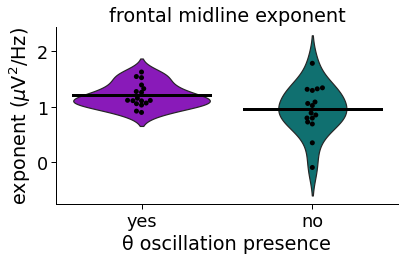

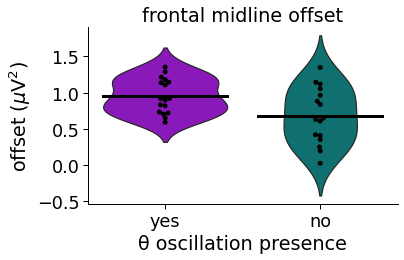

In [170]:
dp_plot.plot_violin_swarms(data=df_all_theta_ret_avg, parameter='exponent', frequency_band='theta_presence', zero=False, save_fig=True)
dp_plot.plot_violin_swarms(data=df_all_theta_ret_avg, parameter='offset', frequency_band='theta_presence', zero=False, save_fig=True)

# Correlation of aperiodic with working memory capacity

24 in total:
2: capacity measuremens (K and main task)
2: EEG measurements (offset and exponent)
2: electrode clusters (frontal and occipital)
3: time windows (pre-stim, post-stim, difference pre-post)

In [171]:
df_all_theta_diff_avg.head()

,trial_n,exponent,offset,power,cf,peak_perc,bandpower,auc,auc_log_osc,auc_lin_osc,r2s,wm_capacity,osc_presence
sub_id,,,,,,,,,,,,,
1.0,70.966444,-0.076143,-0.111864,0.062582,0.012112,-5.712230,-0.127696,-0.274071,0.063680,0.016397,NaN,3.003704,yes
2.0,62.888518,0.029327,0.010777,-0.006402,0.046987,3.317111,-0.455470,-0.994744,-0.108964,-0.708745,NaN,2.961111,yes
3.0,59.193131,-0.146487,-0.207330,0.018951,0.105777,1.473487,-0.616269,-1.254166,0.138247,-0.451294,NaN,3.553704,yes
4.0,66.352151,0.044015,-0.031590,-0.009829,-0.720896,0.496269,-1.749751,-3.368050,-0.038773,-2.341748,NaN,2.544444,yes
5.0,63.914362,-0.161359,-0.221981,0.060434,0.079386,-8.079994,-0.366972,-0.666698,0.048692,-0.054681,NaN,2.618519,no


In [172]:
print(pg.corr(x=df_all_theta_diff_avg['wm_capacity'], y=df_all_theta_diff_avg['exponent']))
print(pg.corr(x=df_all_theta_bas_avg['wm_capacity'], y=df_all_theta_bas_avg['exponent']))
print(pg.corr(x=df_all_theta_ret_avg['wm_capacity'], y=df_all_theta_ret_avg['exponent']))

          n         r         CI95%     p-val   BF10     power
pearson  33 -0.149126  [-0.47, 0.2]  0.407514  0.301  0.132155
          n         r          CI95%     p-val   BF10     power
pearson  33 -0.266094  [-0.56, 0.08]  0.134448  0.634  0.327392
          n         r          CI95%     p-val   BF10    power
pearson  33 -0.270091  [-0.56, 0.08]  0.128476  0.656  0.33605


In [173]:
print(pg.corr(x=df_all_theta_diff_avg['wm_capacity'], y=df_all_theta_diff_avg['offset']))
print(pg.corr(x=df_all_theta_bas_avg['wm_capacity'], y=df_all_theta_bas_avg['offset']))
print(pg.corr(x=df_all_theta_ret_avg['wm_capacity'], y=df_all_theta_ret_avg['offset']))

          n         r         CI95%     p-val   BF10     power
pearson  33 -0.189243  [-0.5, 0.16]  0.291531  0.369  0.185653
          n        r         CI95%     p-val   BF10     power
pearson  33 -0.32489  [-0.6, 0.02]  0.065068  1.106  0.464291
          n         r         CI95%     p-val   BF10    power
pearson  33 -0.342275  [-0.61, 0.0]  0.051205  1.339  0.50756


Text(0.5, 1.0, 'exp 2')

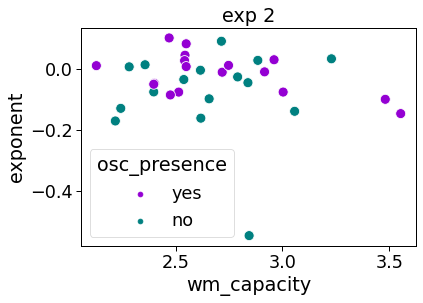

In [174]:
# Figure showing dots with different colors for osc_presence yes or no
# Delta aperiodic on y axis
# Average WM on x axis

theta_no_theta = {'yes': 'darkviolet',
                'no': 'teal'}


sns.scatterplot(data=df_all_theta_diff_avg, x='wm_capacity', y='exponent', hue='osc_presence', palette=theta_no_theta, s=100)
plt.title('exp 2')

<AxesSubplot:xlabel='wm_capacity', ylabel='exponent'>

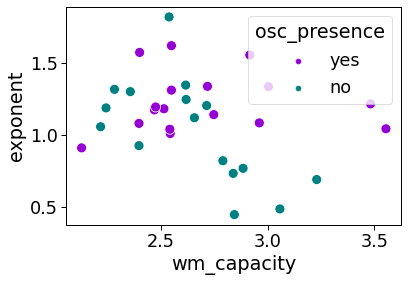

In [175]:
sns.scatterplot(data=df_all_theta_bas_avg, x='wm_capacity', y='exponent', hue='osc_presence', palette=theta_no_theta, s=100)

<AxesSubplot:xlabel='wm_capacity', ylabel='exponent'>

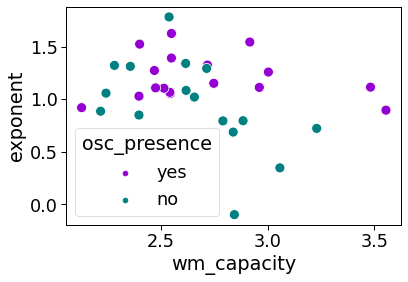

In [176]:
sns.scatterplot(data=df_all_theta_ret_avg, x='wm_capacity', y='exponent', hue='osc_presence', palette=theta_no_theta, s=100)

# THETA - Gender regression

In [177]:
# rename subject ID column so it matches with the other dataframe I make later on
dem.rename(columns={'Subject Num': 'sub_id'}, inplace=True)


In [178]:
# Create array with all sub id
all_subs = np.arange(1, 31+1, 1)
# Delete number 24 since it was ommited in the analysis earlier
all_subs = np.delete(all_subs, 24-1)

# Create array with subs who have no theta (residuals of all_subs & SUB_THETA)
sub_no_theta = []

for idx, sub in enumerate(all_subs):
    boolean = all_subs[idx] in SUB_THETA
    
    if not boolean:  # so basically, if FALSE --> then include that sub_id as no_theta
        sub_no_theta.append(sub)


In [179]:
# Now it's time to create a pandas dataframe with SUB_THETA and sub_no_theta
# We need the sub_id's as one column, and add a column whether they have theta or not
df_yes_theta = pd.DataFrame({'sub_id' : SUB_THETA, 'theta_presence' : 'yes'})
df_no_theta = pd.DataFrame({'sub_id' : sub_no_theta, 'theta_presence' : 'no'})

# Combine the 2 dataframes
df_theta = pd.concat([df_yes_theta, df_no_theta], axis=0)

In [180]:
# Now combine the dem dataframe with theta dataframe based on sub_id
df_theta_dem = pd.merge(df_theta, dem, on='sub_id', how='inner')

# remove sub_id 7 and 19 according to demographics notes
df_theta_dem.drop(df_theta_dem.index[df_theta_dem['sub_id'] == 7], inplace=True)
df_theta_dem.drop(df_theta_dem.index[df_theta_dem['sub_id'] == 19], inplace=True)
# also drop the last column
df_theta_dem.drop(labels=['Unnamed: 3'], axis=1, inplace=True)

In [181]:
# Either logistic regression <-- only when outcome variable is continous. So this one is off the table
# Or Pearson Chi-Square or Likelihood Ratio according to the stats decision tree (flow chart)

expected, observed, stats = pg.chi2_independence(data=df_theta_dem, x='Sex', y='theta_presence')

In [182]:
expected

theta_presence,no,yes
Sex,,
F,8.685714,10.314286
M,7.314286,8.685714


In [183]:
observed

theta_presence,no,yes
Sex,,
F,8.5,10.5
M,7.5,8.5


In [184]:
stats

,test,lambda,chi2,dof,pval,cramer,power
0,pearson,1.000000,0.016001,1.0,0.899340,0.021382,0.051835
1,cressie-read,0.666667,0.016000,1.0,0.899343,0.021381,0.051835
2,log-likelihood,0.000000,0.015999,1.0,0.899347,0.021380,0.051835
3,freeman-tukey,-0.500000,0.015998,1.0,0.899348,0.021380,0.051835
4,mod-log-likelihood,-1.000000,0.015998,1.0,0.899349,0.021380,0.051835
5,neyman,-2.000000,0.015999,1.0,0.899347,0.021380,0.051835


## Performance differences between theta or not theta

# Sandbox for average WM correlation with aperiodic

K = N × (H − FA), where N represents the set size, H is the hit rate (proportion of correct change trials), and FA is the false alarm rate (proportion of incorrect no-change trials). This formula (Cowan, 2001) is most appropriate for single-probe displays like the ones used here (Rouder, Morey, Morey, & Cowan, 2011). Average change detection performance (mean K) was calculated as the average of performance for all set sizes (three, six, and eight items).

In [185]:
# Start looping over participants
from colourfulbirds import exp2_functionsforFOOOF as dp
from colourfulbirds import datahelper

beh_dat_path = "/Users/quirine/Documents/Projects/WM_fooof/Experiment_2/Behavior"

num_subjects = 48
beh_dat_avg = []
K_3_avg = []
K_6_avg = []
K_8_avg = []
K_avg_avg = []
K_avg = []
subs = []

for count, sub in enumerate(range(1, num_subjects + 1)):
    # print(sub)

    # sub 7 doesn't have a file, sub 19 & 43 have low trial_n
    if sub == (7 or 19 or 43):
        continue
    
    subs.append(sub)
    
    beh_dat = None
    beh_dat_K = None

    if sub < 10:
        sub = '0' + str(sub)
        
    sub_beh_file = str(sub) + '_discreteWR_biLat_ss6.mat'
    sub_beh_file_K = str(sub) + '_ColorK.mat'

    # load data
    beh_dat = datahelper.loadmat(beh_dat_path + "/" + sub_beh_file)
    beh_dat_K = datahelper.loadmat(beh_dat_path + "/" + sub_beh_file_K)

    # select trial accuracy
    beh_dat_acc = beh_dat['data']['trialAcc']
    beh_dat_k_acc = beh_dat_K['stim']['accuracy'] # 1=correct, 0=incorrect
    beh_dat_k_ss = beh_dat_K['stim']['setSize'] # 3, 6, 8
    beh_dat_ch = beh_dat_K['stim']['change'] # 1=change, 0=no change


    # Calculate K
    beh_dat_k_acc = beh_dat_K['stim']['accuracy'].flatten() # 1=correct, 0=incorrect
    beh_dat_k_ss = beh_dat_K['stim']['setSize'].flatten() # 3, 6, 8
    beh_dat_ch = beh_dat_K['stim']['change'].flatten() # 1=change, 0=no change

    data_to_df = {'accuracy': beh_dat_k_acc,
                'setsize': beh_dat_k_ss,
                'change': beh_dat_ch}
    df = pd.DataFrame(data_to_df)
    
    # Calculate amount of trials per setsize
    n_3 = df[df['setsize'] == 3].shape[0]
    n_6 = df[df['setsize'] == 6].shape[0]
    n_8 = df[df['setsize'] == 8].shape[0]

    # Calucate hit rate (correct when there was a change) within each setsize
    hit_3 = df.query('setsize==3 & change==1 & accuracy==1').shape[0] / n_3
    hit_6 = df.query('setsize==6 & change==1 & accuracy==1').shape[0] / n_6
    hit_8 = df.query('setsize==8 & change==1 & accuracy==1').shape[0] / n_8

    # Calucalte false alarms (incorrect and no change) within each setsize
    fa_3 = df.query('setsize==3 & change==0 & accuracy==0').shape[0] / n_3
    fa_6 = df.query('setsize==6 & change==0 & accuracy==0').shape[0] / n_6
    fa_8 = df.query('setsize==8 & change==0 & accuracy==0').shape[0] / n_8

    # Calulate K per set size --> K = N × (H − FA)
    K_3 = 3 * (hit_3 - fa_3)
    K_6 = 6 * (hit_6 - fa_6)
    K_8 = 8 * (hit_8 - fa_8)
    K_avg = np.mean([K_3, K_6, K_8])

    # plot per participant
    # plt.figure()
    # plt.hist(beh_dat_acc)
    # plt.title(sub)
    # plt.show()


    # Save for each ppn
    beh_dat_avg.append(np.nanmean(beh_dat_acc, axis=(0,1)))
    K_3_avg.append(K_3)
    K_6_avg.append(K_6)
    K_8_avg.append(K_8)
    K_avg_avg.append(K_avg)
    # K_avg.append(all_K)

    # print(count)
    # K_avg[count,:] = all_K

    # if count==0:
    #     K_avg = all_K
    # else:
    #     K_avg = np.concatenate((K_avg, all_K), axis=1)



K_to_dic = {'sub_id': subs,
            'K_3': K_3_avg,
            'K_6': K_6_avg,
            'K_8': K_8_avg,
            'K_avg': K_avg_avg}
df_k = pd.DataFrame(K_to_dic)


In [186]:
df_k.head()

,sub_id,K_3,K_6,K_8,K_avg
0,1,1.3750,1.625,0.833333,1.277778
1,2,1.3750,2.125,0.833333,1.444444
2,3,1.4375,2.500,2.666667,2.201389
3,4,1.3125,1.375,2.000000,1.562500
4,5,1.4375,1.500,1.666667,1.534722


### THETA -- frontal midline

In [187]:
df_k.head()

,sub_id,K_3,K_6,K_8,K_avg
0,1,1.3750,1.625,0.833333,1.277778
1,2,1.3750,2.125,0.833333,1.444444
2,3,1.4375,2.500,2.666667,2.201389
3,4,1.3125,1.375,2.000000,1.562500
4,5,1.4375,1.500,1.666667,1.534722


In [188]:
df_all_theta_diff_avg.head()

,trial_n,exponent,offset,power,cf,peak_perc,bandpower,auc,auc_log_osc,auc_lin_osc,r2s,wm_capacity,osc_presence
sub_id,,,,,,,,,,,,,
1.0,70.966444,-0.076143,-0.111864,0.062582,0.012112,-5.712230,-0.127696,-0.274071,0.063680,0.016397,NaN,3.003704,yes
2.0,62.888518,0.029327,0.010777,-0.006402,0.046987,3.317111,-0.455470,-0.994744,-0.108964,-0.708745,NaN,2.961111,yes
3.0,59.193131,-0.146487,-0.207330,0.018951,0.105777,1.473487,-0.616269,-1.254166,0.138247,-0.451294,NaN,3.553704,yes
4.0,66.352151,0.044015,-0.031590,-0.009829,-0.720896,0.496269,-1.749751,-3.368050,-0.038773,-2.341748,NaN,2.544444,yes
5.0,63.914362,-0.161359,-0.221981,0.060434,0.079386,-8.079994,-0.366972,-0.666698,0.048692,-0.054681,NaN,2.618519,no


In [189]:
# Combine K with other dataframe that has exponent
df_all_theta_diff_avg = pd.merge(df_all_theta_diff_avg, df_k, how='inner', on='sub_id')
df_all_theta_bas_avg = pd.merge(df_all_theta_bas_avg, df_k, how='inner', on='sub_id')
df_all_theta_ret_avg = pd.merge(df_all_theta_ret_avg, df_k, how='inner', on='sub_id')


In [190]:
df_all_theta_ret_avg.head()

,sub_id,trial_n,exponent,offset,power,cf,peak_perc,bandpower,auc,auc_log_osc,auc_lin_osc,r2s,wm_capacity,osc_presence,K_3,K_6,K_8,K_avg
0,1.0,70.966444,1.259467,0.897459,0.312137,6.014493,68.549161,3.862699,8.022974,0.632229,5.214844,0.739263,3.003704,yes,1.3750,1.625,0.833333,1.277778
1,2.0,62.888518,1.113325,0.732864,0.302595,6.122556,70.459785,3.225711,6.358554,0.572276,3.906936,0.692545,2.961111,yes,1.3750,2.125,0.833333,1.444444
2,3.0,59.193131,0.896768,0.719065,0.257802,5.877736,75.113345,4.769701,8.793295,0.452710,5.453537,0.712939,3.553704,yes,1.4375,2.500,2.666667,2.201389
3,4.0,66.352151,1.054452,1.105741,0.124298,5.726053,84.287313,5.052544,9.819251,0.270849,4.293811,0.695735,2.544444,yes,1.3125,1.375,2.000000,1.562500
4,5.0,63.914362,1.085050,0.881332,0.237958,5.940180,71.234940,3.488233,6.948079,0.411078,3.575101,0.723898,2.618519,no,1.4375,1.500,1.666667,1.534722


# Is WM capacity different between people having theta oscillations or not?

In [191]:
# t-test for unparametric alternative
pg.ttest(df_all_theta_diff_avg.query('osc_presence == "yes"')['wm_capacity'].values, 
               df_all_theta_diff_avg.query('osc_presence == "no"')['wm_capacity'].values)

# unparametric alternative
# pg.mwu(df_all_theta_diff_avg.query('osc_presence == "yes"')['exponent'].values, 
#                df_all_theta_diff_avg.query('osc_presence == "no"')['exponent'].values)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,0.511609,29.995837,two-sided,0.612671,"[-0.18, 0.3]",0.176847,0.368,0.078181


In [192]:
# t-test for unparametric alternative
pg.ttest(df_all_theta_diff_avg.query('osc_presence == "yes"')['K_avg'].values, 
               df_all_theta_diff_avg.query('osc_presence == "no"')['K_avg'].values)

# unparametric alternative
# pg.mwu(df_all_theta_diff_avg.query('osc_presence == "yes"')['exponent'].values, 
#                df_all_theta_diff_avg.query('osc_presence == "no"')['exponent'].values)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,0.374348,30.889474,two-sided,0.710703,"[-0.21, 0.31]",0.129894,0.351,0.065101


is K-values correlated to overall WM-capacity on this task? --> yes

In [193]:
pg.corr(x=df_all_theta_diff_avg['K_avg'], y=df_all_theta_diff_avg['wm_capacity'])

,n,r,CI95%,p-val,BF10,power
pearson,33,0.375941,"[0.04, 0.64]",0.031073,2.009,0.592314


<AxesSubplot:xlabel='K_avg', ylabel='wm_capacity'>

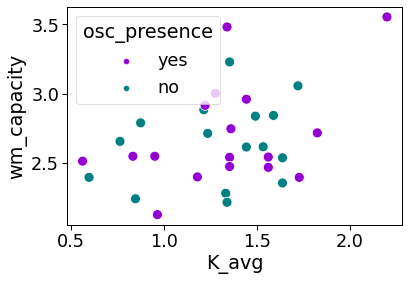

In [194]:
theta_no_theta = {'yes': 'darkviolet',
                'no': 'teal'}

sns.scatterplot(x='K_avg', y='wm_capacity', hue='osc_presence', data=df_all_theta_diff_avg, palette=theta_no_theta, s=100)

Is having theta or not related to K-values? --> NO difference in performance on K-values nor on wm capacity on the task

In [195]:
pg.normality(data=df_all_theta_diff_avg, dv='K_avg', group='osc_presence')

,W,pval,normal
yes,0.979419,0.951633,True
no,0.907777,0.107156,True


In [196]:
pg.homoscedasticity(data=df_all_theta_diff_avg, dv='K_avg', group='osc_presence', method='levene')

,W,pval,equal_var
levene,0.026522,0.871688,True


In [197]:
pg.ttest(x=df_all_theta_diff_avg.query('osc_presence=="yes"')['K_avg'],
         y=df_all_theta_diff_avg.query('osc_presence=="no"')['K_avg'])

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,0.374348,30.889474,two-sided,0.710703,"[-0.21, 0.31]",0.129894,0.351,0.065101


In [198]:
pg.normality(data=df_all_theta_diff_avg, dv='wm_capacity', group='osc_presence')

,W,pval,normal
yes,0.880388,0.032261,False
no,0.963933,0.733328,True


In [199]:
pg.homoscedasticity(data=df_all_theta_diff_avg, dv='wm_capacity', group='osc_presence', method='levene')

,W,pval,equal_var
levene,0.104378,0.748807,True


In [200]:
pg.ttest(x=df_all_theta_diff_avg.query('osc_presence=="yes"')['wm_capacity'],
         y=df_all_theta_diff_avg.query('osc_presence=="no"')['wm_capacity'])

# pg.mwu(x=df_all_theta_diff_avg.query('osc_presence=="yes"')['wm_capacity'],
#          y=df_all_theta_diff_avg.query('osc_presence=="no"')['wm_capacity'])


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,0.511609,29.995837,two-sided,0.612671,"[-0.18, 0.3]",0.176847,0.368,0.078181


Correlations

In [201]:
# stats for correlation over osc present or not
print(pg.corr(x=df_all_theta_diff_avg['K_avg'], y=df_all_theta_diff_avg['exponent']))
print(pg.corr(x=df_all_theta_bas_avg['K_avg'], y=df_all_theta_bas_avg['exponent']))
print(pg.corr(x=df_all_theta_ret_avg['K_avg'], y=df_all_theta_ret_avg['exponent']))

          n         r          CI95%     p-val   BF10     power
pearson  33 -0.136521  [-0.46, 0.22]  0.448708  0.285  0.118283
          n         r          CI95%     p-val  BF10     power
pearson  33 -0.084398  [-0.42, 0.27]  0.640522  0.24  0.075121
          n         r          CI95%     p-val   BF10   power
pearson  33 -0.113899  [-0.44, 0.24]  0.527955  0.262  0.0968


In [202]:
print(pg.corr(x=df_all_theta_diff_avg['K_avg'], y=df_all_theta_diff_avg['offset']))
print(pg.corr(x=df_all_theta_bas_avg['K_avg'], y=df_all_theta_bas_avg['offset']))
print(pg.corr(x=df_all_theta_ret_avg['K_avg'], y=df_all_theta_ret_avg['offset']))

          n         r          CI95%     p-val   BF10     power
pearson  33 -0.055277  [-0.39, 0.29]  0.759962  0.226  0.060391
          n         r          CI95%     p-val   BF10     power
pearson  33  0.120133  [-0.23, 0.45]  0.505463  0.268  0.102289
          n         r          CI95%     p-val  BF10     power
pearson  33  0.082935  [-0.27, 0.41]  0.646344  0.24  0.074226


Text(0.5, 1.0, 'exp 2')

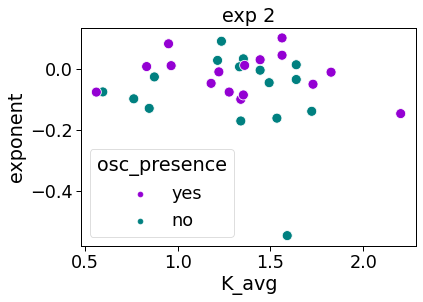

In [203]:
theta_no_theta = {'yes': 'darkviolet',
                'no': 'teal'}

sns.scatterplot(x='K_avg', y='exponent', hue='osc_presence', data=df_all_theta_diff_avg, palette=theta_no_theta, s=100)
plt.title('exp 2')

Text(0.5, 1.0, 'exp 2')

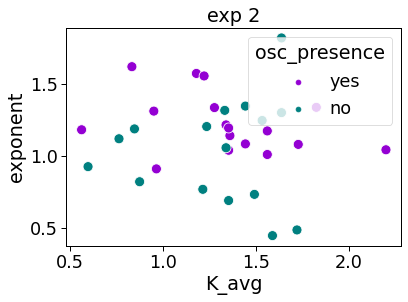

In [204]:
sns.scatterplot(x='K_avg', y='exponent', hue='osc_presence', data=df_all_theta_bas_avg, palette=theta_no_theta, s=100)
plt.title('exp 2')

Text(0.5, 1.0, 'exp 2')

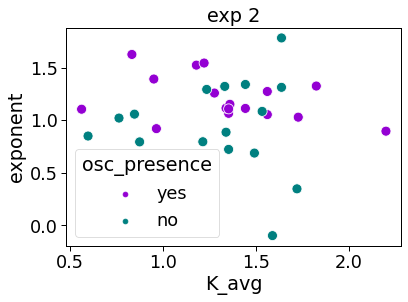

In [205]:
sns.scatterplot(x='K_avg', y='exponent', hue='osc_presence', data=df_all_theta_ret_avg, palette=theta_no_theta, s=100)
plt.title('exp 2')

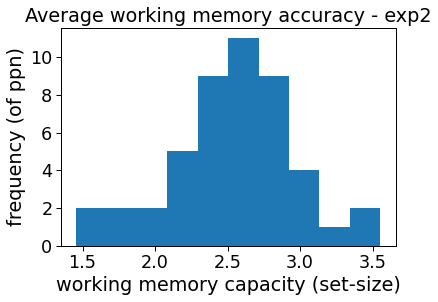

In [206]:
plt.hist(beh_dat_avg)
plt.title('Average working memory accuracy - exp2')
plt.ylabel('frequency (of ppn)')
plt.xlabel('working memory capacity (set-size)')
plt.show()

#### FM exponent baseline

In [207]:
df_theta_avg_bas_avg = df_all_theta_bas.groupby(['sub_id']).mean()
# MErge with dataframe that has K information
df_bas_k = pd.merge(df_theta_avg_bas_avg, df_k, how='inner', on='sub_id')

df_bas_k.head()

,sub_id,trial_n,exponent,offset,power,cf,peak_perc,bandpower,auc,auc_log_osc,auc_lin_osc,r2s,wm_capacity,osc_presence,K_3,K_6,K_8,K_avg
0,1.0,70.966444,1.335610,1.009322,0.249555,6.050459,74.261391,3.990396,8.297045,0.568549,5.198446,0.757075,3.003704,1.0,1.3750,1.625,0.833333,1.277778
1,2.0,62.888518,1.083998,0.722087,0.308997,5.920979,67.142674,3.681180,7.353297,0.681240,4.615681,0.682732,2.961111,1.0,1.3750,2.125,0.833333,1.444444
2,3.0,59.193131,1.043255,0.926395,0.238852,6.057700,73.639858,5.385970,10.047461,0.314463,5.904830,0.735783,3.553704,1.0,1.4375,2.500,2.666667,2.201389
3,4.0,66.352151,1.010437,1.137331,0.134128,6.086233,83.791045,6.802295,13.187301,0.309622,6.635559,0.715791,2.544444,1.0,1.3125,1.375,2.000000,1.562500
4,5.0,63.914362,1.246409,1.103313,0.177525,6.083974,79.314934,3.855205,7.614777,0.362386,3.629782,0.723909,2.618519,0.0,1.4375,1.500,1.666667,1.534722


Text(0.5, 1.0, 'Exp2: Average WM capacity (K) ~ baseline fm exponent')

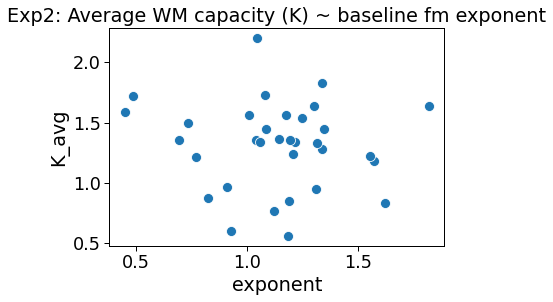

In [208]:
sns.scatterplot(x='exponent', y='K_avg', data=df_bas_k, s=100)
plt.title('Exp2: Average WM capacity (K) ~ baseline fm exponent')

### ALPHA -- occipital

Can't really do this, since there was no difference between performance for exponent anyway. But we can do this for experiment 1!

In [209]:
df_all_alpha_diff_avg = df_alpha_avg_diff.groupby('sub_id').mean()
df_all_alpha_bas_avg = df_alpha_avg_bas.groupby('sub_id').mean()
df_all_alpha_ret_avg = df_alpha_avg_ret.groupby('sub_id').mean()

In [210]:
# Combine K with other dataframe that has exponent
df_all_alpha_diff_avg = pd.merge(df_all_alpha_diff_avg, df_k, how='inner', on='sub_id')
df_all_alpha_bas_avg = pd.merge(df_all_alpha_bas_avg, df_k, how='inner', on='sub_id')
df_all_alpha_ret_avg = pd.merge(df_all_alpha_ret_avg, df_k, how='inner', on='sub_id')

In [211]:
print(pg.corr(x=df_all_alpha_diff_avg['wm_capacity'], y=df_all_alpha_diff_avg['exponent']))
print(pg.corr(x=df_all_alpha_bas_avg['wm_capacity'], y=df_all_alpha_bas_avg['exponent']))
print(pg.corr(x=df_all_alpha_ret_avg['wm_capacity'], y=df_all_alpha_ret_avg['exponent']))

          n         r         CI95%    p-val   BF10     power
pearson  26 -0.133613  [-0.5, 0.27]  0.51523  0.298  0.099879
          n         r          CI95%     p-val   BF10     power
pearson  26 -0.084673  [-0.46, 0.31]  0.680886  0.264  0.069244
          n         r          CI95%     p-val   BF10     power
pearson  26 -0.117031  [-0.48, 0.28]  0.569114  0.284  0.087817


In [212]:
print(pg.corr(x=df_all_alpha_diff_avg['wm_capacity'], y=df_all_alpha_diff_avg['offset']))
print(pg.corr(x=df_all_alpha_bas_avg['wm_capacity'], y=df_all_alpha_bas_avg['offset']))
print(pg.corr(x=df_all_alpha_ret_avg['wm_capacity'], y=df_all_alpha_ret_avg['offset']))

          n         r          CI95%     p-val   BF10    power
pearson  26 -0.155065  [-0.51, 0.25]  0.449418  0.319  0.11816
          n         r          CI95%     p-val   BF10     power
pearson  26 -0.161386  [-0.52, 0.24]  0.430919  0.327  0.124138
          n         r         CI95%     p-val   BF10     power
pearson  26 -0.201915  [-0.55, 0.2]  0.322579  0.387  0.169083


In [213]:
print(pg.corr(x=df_all_alpha_diff_avg['K_avg'], y=df_all_alpha_diff_avg['exponent']))
print(pg.corr(x=df_all_alpha_bas_avg['K_avg'], y=df_all_alpha_bas_avg['exponent']))
print(pg.corr(x=df_all_alpha_ret_avg['K_avg'], y=df_all_alpha_ret_avg['exponent']))

          n         r          CI95%     p-val   BF10     power
pearson  26 -0.260782  [-0.59, 0.14]  0.198186  0.534  0.255244
          n         r          CI95%     p-val   BF10    power
pearson  26  0.001493  [-0.39, 0.39]  0.994225  0.243  0.04942
          n         r          CI95%     p-val   BF10    power
pearson  26 -0.062007  [-0.44, 0.33]  0.763479  0.254  0.05997


In [214]:
print(pg.corr(x=df_all_alpha_diff_avg['K_avg'], y=df_all_alpha_diff_avg['offset']))
print(pg.corr(x=df_all_alpha_bas_avg['K_avg'], y=df_all_alpha_bas_avg['offset']))
print(pg.corr(x=df_all_alpha_ret_avg['K_avg'], y=df_all_alpha_ret_avg['offset']))

          n         r          CI95%     p-val   BF10     power
pearson  26 -0.179797  [-0.53, 0.22]  0.379458  0.351  0.143122
          n         r         CI95%     p-val   BF10     power
pearson  26  0.203775  [-0.2, 0.55]  0.318047  0.391  0.171425
          n         r         CI95%    p-val   BF10     power
pearson  26  0.143279  [-0.26, 0.5]  0.48501  0.307  0.107737


#### OCCIPITAL EXPONENT BASELINE

In [215]:
# Calculate average exponent regardless of hemisphere or set-size condition
df_alpha_avg_bas_avg = df_alpha_avg_bas.groupby(['sub_id']).mean()
df_alpha_avg_bas_avg.head()

,trial_n,exponent,offset,power,cf,peak_perc,bandpower,auc,auc_log_osc,auc_lin_osc,r2s,wm_capacity,osc_presence
sub_id,,,,,,,,,,,,,
1.0,71.896868,1.279682,0.684238,1.551496,10.795587,10.829736,7.754700,34.325131,4.182004,30.168829,0.788832,3.003704,1.0
2.0,61.673718,0.774309,0.311796,0.861330,10.418723,27.459016,2.380352,10.254896,2.271900,7.903637,0.559022,2.961111,1.0
3.0,58.732265,1.387888,1.024298,1.636668,10.754346,6.598660,16.632089,73.408726,4.247752,64.946649,0.828430,3.553704,1.0
4.0,67.874768,1.222330,1.239617,1.786534,10.926835,2.246269,43.424575,182.820843,4.858301,161.970840,0.804208,2.544444,1.0
5.0,63.488627,1.077807,0.786970,0.837942,10.442461,24.952718,3.674100,15.809373,2.274820,12.303741,0.691235,2.618519,1.0


In [216]:
# MErge with dataframe that has K information
df_bas_k = pd.merge(df_alpha_avg_bas_avg, df_k, how='inner', on='sub_id')
df_bas_k.head()

,sub_id,trial_n,exponent,offset,power,cf,peak_perc,bandpower,auc,auc_log_osc,auc_lin_osc,r2s,wm_capacity,osc_presence,K_3,K_6,K_8,K_avg
0,1.0,71.896868,1.279682,0.684238,1.551496,10.795587,10.829736,7.754700,34.325131,4.182004,30.168829,0.788832,3.003704,1.0,1.3750,1.625,0.833333,1.277778
1,2.0,61.673718,0.774309,0.311796,0.861330,10.418723,27.459016,2.380352,10.254896,2.271900,7.903637,0.559022,2.961111,1.0,1.3750,2.125,0.833333,1.444444
2,3.0,58.732265,1.387888,1.024298,1.636668,10.754346,6.598660,16.632089,73.408726,4.247752,64.946649,0.828430,3.553704,1.0,1.4375,2.500,2.666667,2.201389
3,4.0,67.874768,1.222330,1.239617,1.786534,10.926835,2.246269,43.424575,182.820843,4.858301,161.970840,0.804208,2.544444,1.0,1.3125,1.375,2.000000,1.562500
4,5.0,63.488627,1.077807,0.786970,0.837942,10.442461,24.952718,3.674100,15.809373,2.274820,12.303741,0.691235,2.618519,1.0,1.4375,1.500,1.666667,1.534722


Text(0.5, 1.0, 'Exp2: Average WM capacity (K) ~ baseline occipital exponent')

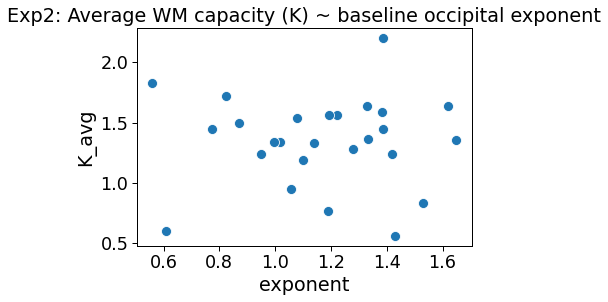

In [217]:
sns.scatterplot(x='exponent', y='K_avg', data=df_bas_k, s=100)
plt.title('Exp2: Average WM capacity (K) ~ baseline occipital exponent')


In [218]:
df_alpha_avg_diff.head()

,performance,lateralization,bas_ret_diff,sub_id,trial_n,exponent,offset,power,cf,peak_perc,bandpower,auc,auc_log_osc,auc_lin_osc,r2s,wm_capacity,osc_presence
1,good,contra,diff,1.0,73.648438,-0.029541,-0.091696,-0.070188,-0.297870,-6.000000,-2.756096,-11.371259,-0.293643,-10.176183,NaN,3.003704,1.0
4,good,ipsi,diff,1.0,73.648438,0.158127,0.142061,-0.070799,-0.194992,-6.666667,-3.055478,-12.128853,-0.520705,-10.982709,NaN,3.003704,1.0
7,poor,contra,diff,1.0,70.145299,-0.079227,-0.167419,-0.056867,-0.166147,0.000000,-2.526858,-10.560398,-0.246325,-9.433092,NaN,3.003704,1.0
10,poor,ipsi,diff,1.0,70.145299,-0.114677,-0.178668,0.004511,-0.090166,-5.035971,-2.977895,-12.062198,-0.251907,-10.827544,NaN,3.003704,1.0
1,good,contra,diff,2.0,63.866667,-0.050179,-0.097260,-0.023215,0.325344,0.781250,-0.127916,-0.564120,-0.052918,-0.361849,NaN,2.961111,1.0


In [219]:
# Take avearge over conditions (wm performance)
df_alpha_diff_avg = df_alpha_avg_diff.groupby(['sub_id', 'performance']).mean()
df_alpha_diff_avg.head()

trial_n  exponent    offset     power        cf  \
sub_id performance                                                      
1.0    good         73.648438  0.064293  0.025182 -0.070494 -0.246431   
       poor         70.145299 -0.096952 -0.173044 -0.026178 -0.128157   
2.0    good         63.866667 -0.035524 -0.071984  0.005506  0.083195   
       poor         59.480769 -0.028676 -0.077194  0.095462  0.041917   
3.0    good         88.421053 -0.035436 -0.097960  0.029433  0.054063   

                    peak_perc  bandpower        auc  auc_log_osc  auc_lin_osc  \
sub_id performance                                                              
1.0    good         -6.333333  -2.905787 -11.750056    -0.407174   -10.579446   
       poor         -2.517986  -2.752376 -11.311298    -0.249116   -10.130318   
2.0    good          0.781250   0.004840   0.088210     0.045510     0.219227   
       poor         -4.098361   0.309103   1.393530     0.321309     1.465708   
3.0    good         -0.842697  -3.467886 -15.191098     0.002534   -13.551431   

                    r2s  wm_capacity  osc_presence  
sub_id performance                                  
1.0    good         NaN     3.003704           1.0  
       poor         NaN     3.003704           1.0  
2.0    good         NaN     2.961111           1.0  
       poor         NaN     2.961111           1.0  
3.0    good         NaN     3.553704           1.0

### exponent: good minus poor

In [220]:
ss_diff = (df_alpha_diff_avg.query('performance=="good"')['exponent'].values - 
        df_alpha_diff_avg.query('performance=="poor"')['exponent'].values)

# Create DF with exponent diffreence of setsize 6 - 1
df_ssdiff = pd.DataFrame({'sub_id': df_alpha_avg_diff['sub_id'].unique(),
              'exponent_ssdiff': ss_diff})

# MErge with dataframe that has K information
df_ssdiff_k = pd.merge(df_ssdiff, df_k, how='inner', on='sub_id')

<AxesSubplot:xlabel='K_avg', ylabel='exponent_ssdiff'>

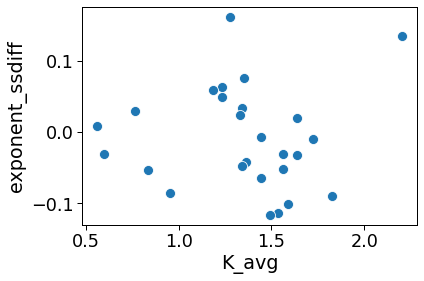

In [221]:
sns.scatterplot(x='K_avg', y='exponent_ssdiff', data=df_ssdiff_k, s=100)

In [222]:
print(pg.corr(x=df_ssdiff_k['K_avg'], y=df_ssdiff_k['exponent_ssdiff']))

          n         r          CI95%     p-val   BF10     power
pearson  26  0.006826  [-0.38, 0.39]  0.973599  0.244  0.049541


#### Relative alpha power between poor and good performance

In [223]:
ss_diff = (df_alpha_diff_avg.query('performance=="good"')['power'].values - 
        df_alpha_diff_avg.query('performance=="poor"')['power'].values)

# Create DF with exponent diffreence of setsize 6 - 1
df_ssdiff = pd.DataFrame({'sub_id': df_alpha_avg_diff['sub_id'].unique(),
              'rel_power_ssdiff': ss_diff})

# MErge with dataframe that has K information
df_ssdiff_k = pd.merge(df_ssdiff, df_k, how='inner', on='sub_id')

<AxesSubplot:xlabel='K_avg', ylabel='rel_power_ssdiff'>

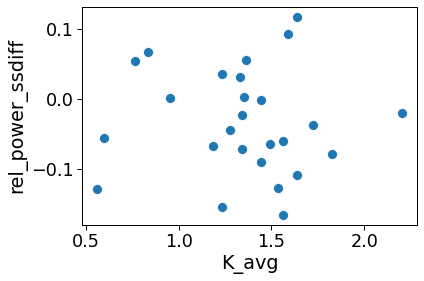

In [224]:
sns.scatterplot(x='K_avg', y='rel_power_ssdiff', data=df_ssdiff_k, s=100)

In [225]:
print(pg.corr(x=df_ssdiff_k['K_avg'], y=df_ssdiff_k['rel_power_ssdiff']))

          n         r          CI95%     p-val   BF10     power
pearson  26 -0.043727  [-0.42, 0.35]  0.832028  0.249  0.054641
